In [2]:
#basic
import numpy as np 
import pandas as pd
import pandas_ta as ta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
#from scipy.fftpack import fft
from matplotlib import pyplot as plt
# D3 modules
from IPython.core.display import display, HTML, Javascript
import IPython.display

#others
import subprocess
import json
from string import Template
import gc
import time
import itertools
import warnings
warnings.filterwarnings('ignore')

#import goslate

%matplotlib inline

## basic description 

### loading data

In [5]:
## loading data
cu_path = '/Users/tjmask/Desktop/quantitative strategy/data/cu9999.csv'
cu_data = pd.read_csv(cu_path,
                      infer_datetime_format=True,
                      parse_dates=[1],
                      dtype={'open': 'int32',
                          'close': 'int32',
                          'high': 'int32',
                          'low': 'int32',
                          'money': 'int64',
                          'volume': 'int32',
                          'open_interest': 'int32'})
cu_data.drop('Unnamed: 0', axis=1, inplace=True)
print("Done!")

Done!


### a simple grasp of dataset

In [3]:
cu_data.head()

,date,open,close,high,low,volume,money,open_interest
0,2005-01-04 09:01:00,29110,29080,29170,29080,3158,459908300,121604
1,2005-01-04 09:02:00,29080,29100,29100,29030,1970,286417600,121806
2,2005-01-04 09:03:00,29110,29060,29110,29060,1418,206240600,122000
3,2005-01-04 09:04:00,29060,29070,29080,29050,942,136908100,122024
4,2005-01-04 09:05:00,29080,29070,29090,29060,1134,164892800,122198


In [4]:
print("There are %d row in this dataset" % len(cu_data))

There are 1106130 row in this dataset


In [5]:
cu_data.nunique()

date             1106130
open                5791
close               5780
high                5785
low                 5773
volume              6546
money             915230
open_interest     174817
dtype: int64

From the result we can see that there are lots of same numbers on 'open','close','high','low','volume'

In [6]:
cu_data.describe()

,open,close,high,low,volume,money,open_interest
count,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06,1.106130e+06
mean,4.956153e+04,4.956156e+04,4.957742e+04,4.954559e+04,8.085406e+02,1.970416e+08,1.980860e+05
std,1.025534e+04,1.025529e+04,1.025862e+04,1.025198e+04,1.291170e+03,3.122175e+08,8.265543e+04
min,2.227000e+04,2.227000e+04,2.231000e+04,2.221000e+04,0.000000e+00,0.000000e+00,2.108000e+04
25%,4.308000e+04,4.308000e+04,4.310000e+04,4.306000e+04,1.640000e+02,3.984230e+07,1.584120e+05
50%,4.931000e+04,4.931000e+04,4.933000e+04,4.930000e+04,4.080000e+02,9.880375e+07,2.043860e+05
75%,5.525000e+04,5.525000e+04,5.527000e+04,5.523000e+04,9.340000e+02,2.271672e+08,2.504420e+05
max,8.550000e+04,8.500000e+04,8.550000e+04,8.482000e+04,3.026620e+05,4.157062e+10,4.751440e+05


From the result we can see that there's no big difference of min 'open', 'close', 'high', 'low', however, there min of both 'volume' and 'money' are 0. This might be because there're no trades in some periods. Or there are some periods that cu surged to its daily trading limit. we need to check those rows.

##### checking trading time periods 

In [7]:
## figure out the morning, afternoon and night period.
unique_time = pd.DataFrame(cu_data.date.map(lambda x: x.time()).unique())
unique_time.columns =["time"]
unique_time.head()

,time
0,09:01:00
1,09:02:00
2,09:03:00
3,09:04:00
4,09:05:00


From the result, we can find out that the morning trade starts from 09:00 to 11:30, the afternoon trade starts from 13:30 to 15:00,, the night trade starts from 21:00 to 01:00. There is a 15-minute break for morning trade from 10:15 to 10:30.

In [8]:
## the num of morning trading
cu_data_new = cu_data.copy()
cu_data_new['date'] = cu_data_new.date.map(lambda x: int(x.time().strftime('%H%M')))
morning_nums = len(cu_data_new[cu_data_new['date'].map(lambda x: x in range(900,1131))])
print("there are %d morning trades in total, %d morning trades per minute on average" \
      %(morning_nums,(morning_nums/135)))


## the num of afternoon trading
afternoon_nums = len(cu_data_new[cu_data_new['date'].map(lambda x: x in range(1330,1501))])
print("there are %d afternoon trades in total, %d afternoon trades per minute on average"\
      % (afternoon_nums,(afternoon_nums/90)))

## the num of night trading
night_nums = len(cu_data_new[cu_data_new['date'].map(lambda x: x in range(2100,2400) or x in range(0,101))])
print("there are %d night trades in total, %d night trades per minute on average"\
      % (night_nums, (night_nums/240)))

there are 475470 morning trades in total, 3522 morning trades per minute on average
there are 316980 afternoon trades in total, 3522 afternoon trades per minute on average
there are 313680 night trades in total, 1307 night trades per minute on average


In [9]:
## creating dataframe for both total and average
df_total = pd.DataFrame([475470,316980,313680],\
                         index = ['morning trades','afternoon trades','night trades'], columns=['total trades'])
df_total
df_average = pd.DataFrame([3522,3522,1307],index = ['morning trades','afternoon trades','night trades'],\
                          columns=['average trades(minutes)'])
df_average

,average trades(minutes)
morning trades,3522
afternoon trades,3522
night trades,1307


Text(0.5, 1.0, 'average trades per minutes')

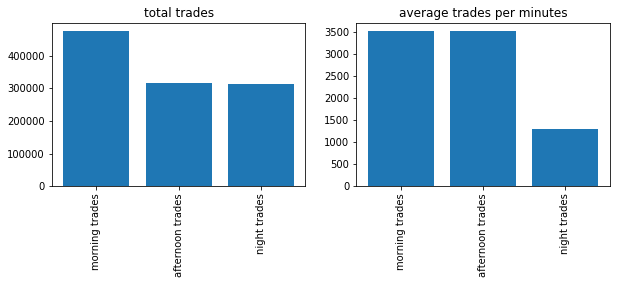

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].bar(df_total.index, df_total.ix[:,0])
ax[0].set_xticklabels(df_total.index, rotation =90)
ax[0].set_title('total trades')

ax[1].bar(df_average.index, df_average.ix[:,0])
ax[1].set_xticklabels(df_average.index, rotation =90)
ax[1].set_title('average trades per minutes')

From the two graph, we can see that the total and average trades in morning is the highest. The average trade of night is kind of low, this is because night trade has longer trading period.

### checking relationship between prices and different time periods

##### checking the mean prices

In [11]:
## group by different date
grouped = cu_data_new.groupby(['date'])

## morning grouped data
morn_group = grouped.mean()[grouped.mean().index.map(lambda x: x in range(900,1131))]

## afternoon grouped data
noon_group = grouped.mean()[grouped.mean().index.map(lambda x: x in range(1330,1501))]

## night grouped data
night_group = grouped.mean()[grouped.mean().index.map(lambda x: x in range(2100,2400) or x in range(0,101))]
night_group.head()

,open,close,high,low,volume,money,open_interest
date,,,,,,,
0,45728.140780,45727.850038,45738.163734,45717.605203,360.174445,7.954027e+07,242227.935731
1,45727.605203,45727.773527,45739.984698,45716.151492,417.418516,9.271474e+07,242218.821729
2,45727.536343,45728.400918,45737.459832,45718.607498,304.543229,6.805048e+07,242211.306809
3,45728.316756,45728.798776,45737.589901,45719.387911,292.220352,6.501092e+07,242199.276205
4,45728.592196,45728.309105,45737.674063,45719.280796,296.157613,6.590805e+07,242188.950268


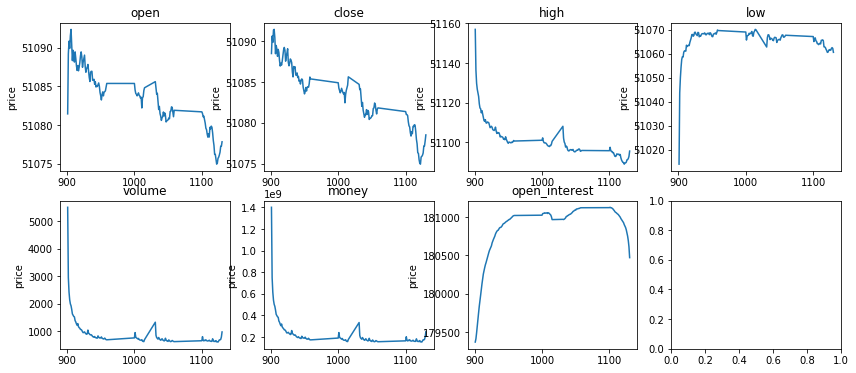

In [12]:
## morning visualization
fig, axes = plt.subplots(2,4, figsize=(14,6), squeeze = False)
for i, columns in enumerate(morn_group.columns):
    x = morn_group.index
    y = morn_group[columns]
    ax = axes[i//4, i%4]
    ax.plot(x,y)
    ax.set_title(columns)
    ax.set_ylabel("price")

For the morning period, the mean open, and close prices fluctuate decreasingly as time, while the mean low price increase dramatically at first several minutes, and then stays kind of stable in the following time. As for mean high price, it is contrary to mean low price, which decreases dramatically at first several minutes, and then decreases gradually. And the trend of open_interest is similar to that of mean low price.

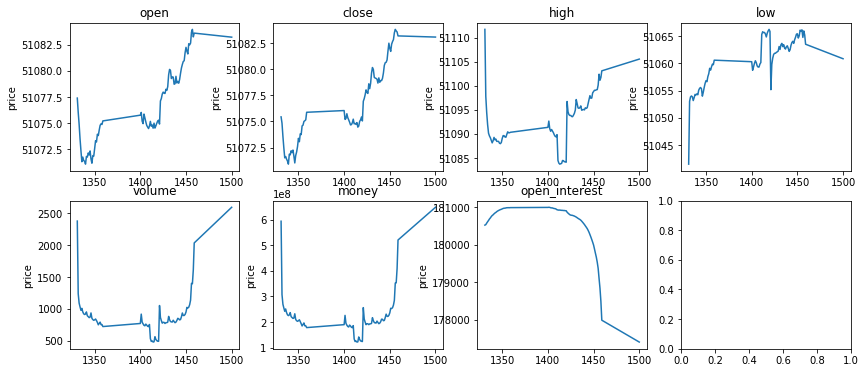

In [13]:
## afternoon visualization
fig, axes = plt.subplots(2,4, figsize=(14,6), squeeze = False)
for i, columns in enumerate(noon_group.columns):
    x = noon_group.index
    y = noon_group[columns]
    ax = axes[i//4, i%4]
    ax.plot(x,y)
    ax.set_title(columns)
    ax.set_ylabel("price")

For the afternoon period, we can see that the mean open and close prices have simiar trends, while the mean high and low prices have kind of contrary trends. 

In [18]:
# adjusitng the date for night data.
night_group['date'] = night_group.index
night_group['date'][0:60] = night_group['date'][0:60] + 2400
night_group['date'][100] = 2460

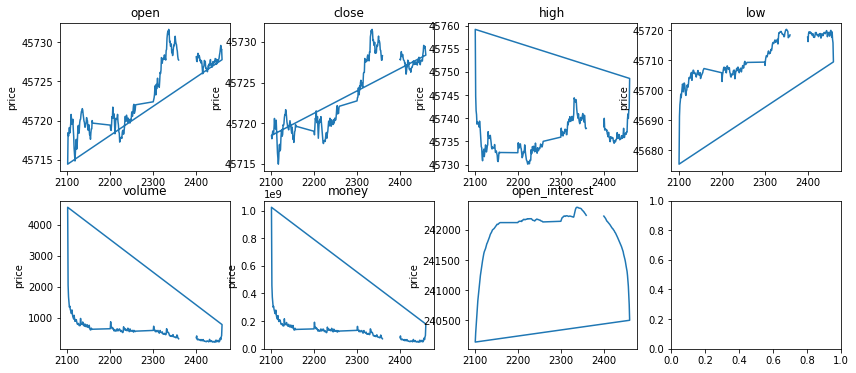

In [19]:
## night visualization
fig, axes = plt.subplots(2,4, figsize=(14,6), squeeze = False)
for i, columns in enumerate(night_group.columns[0:7]):
    x = night_group['date']
    y = night_group[columns]
    ax = axes[i//4, i%4]
    ax.plot(x,y)
    ax.set_title(columns)
    ax.set_ylabel("price")

Fot night period, the conculsion is similar to the conclusion above.

In the end, we find that, we can see that the mean open and close prices have simiar trends, while the mean high and low prices have kind of contrary trends. Those two can be our poential features. One more thing we notice is that, in the morning and night period, the trends and open interests are similar to that of mean low price, while in the afternoon period, those two are kind of contrary. There might be something behind it.

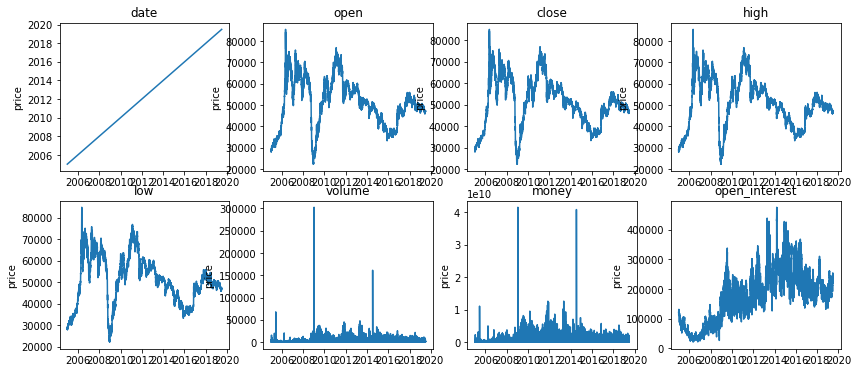

In [20]:
## Look at all varaible trends
fig, axes = plt.subplots(2,4, figsize=(14,88), squeeze = False)
for i, columns in enumerate(cu_data.columns):
    x = cu_data.date
    y = cu_data[columns]
    ax = axes[i//4, i%4]
    ax.plot(x,y)
    ax.set_title(columns)
    ax.set_ylabel('price')

From the graph we can see that there are something interesting. For example, in 2008, all variables have low prices, with relatively high volume, money and open_interest. This is probrably due to financial crisis. Another special year is 2016, in which those variables have similar to that of 2008. This can be a research direction.
However, the graphs seems to non-stationary, thus, we might use the first difference of close price. We still need statistically methods such as ADF test to validate it.

##### checking rows with 'volume' and 'money' are 0

In [21]:
## get the unique days and time periods
unique_dates = cu_data[cu_data['volume']==0].date.map(lambda x: x.date()).unique()
unique_time = cu_data[cu_data['volume']==0].date.map(lambda x: x.time()).unique()

print('There are %d rows that "volume" and "money" are 0' % len(cu_data[cu_data['volume']==0]))
print('There are %d different days that "volume" and "money" are 0' % len(unique_dates))
print('There are %d different time period that "volume" and "money" are 0' % len(unique_time))

There are 25801 rows that "volume" and "money" are 0
There are 1642 different days that "volume" and "money" are 0
There are 465 different time period that "volume" and "money" are 0


In [485]:
cu_data[cu_data['volume']==0].head(50)

,date,open,close,high,low,volume,money,open_interest
175,2005-01-04 14:11:00,28880,28880,28880,28880,0,0,120036
176,2005-01-04 14:12:00,28880,28880,28880,28880,0,0,120036
177,2005-01-04 14:13:00,28880,28880,28880,28880,0,0,120036
178,2005-01-04 14:14:00,28880,28880,28880,28880,0,0,120036
179,2005-01-04 14:15:00,28880,28880,28880,28880,0,0,120036
180,2005-01-04 14:16:00,28880,28880,28880,28880,0,0,120036
181,2005-01-04 14:17:00,28880,28880,28880,28880,0,0,120036
182,2005-01-04 14:18:00,28880,28880,28880,28880,0,0,120036
183,2005-01-04 14:19:00,28880,28880,28880,28880,0,0,120036
184,2005-01-04 14:20:00,28880,28880,28880,28880,0,0,120036


This means, during the 15 years, about 2/3 days and almost every minute-level period once had cu surged to its daily trading limit. That's a lot!!

In [22]:
## figure out the distribution of days for "volume" and "money" are 0
weekdays_0 = pd.DataFrame(unique_dates)[0].map(lambda x: datetime.date.isoweekday(x))
weekdays_0.head()

0    2
1    3
2    4
3    5
4    1
Name: 0, dtype: int64

In [23]:
## figure out the distribution of time period for "volume" and "money" are 0
time_period = cu_data[cu_data['volume']==0].date.map(lambda x: x.time())
time_periods_0 = pd.DataFrame(time_period)['date'].map(lambda x: x.strftime('%H%M'))
time_periods_0 = time_periods_0.astype('int').sort_values(ascending=True)
time_periods_0.tail()

570177     2358
1081903    2359
570178     2359
800938     2359
1083763    2359
Name: date, dtype: int64

Text(0.5, 1.0, 'Hist of time periods')

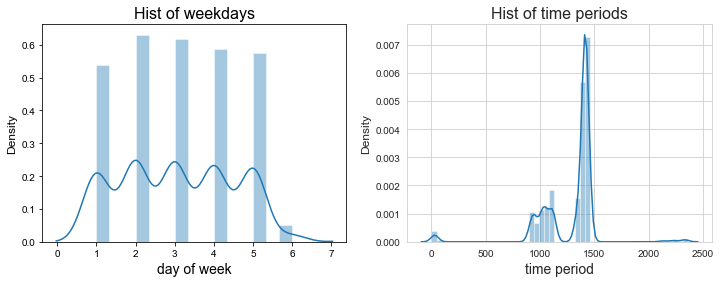

In [24]:
## plotting distributions of weekdays and time periods
# weekdays 
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.set_style("whitegrid")
sns.distplot(weekdays_0)
plt.ylabel('Density', fontsize=12)
plt.xlabel('day of week', fontsize=14)
plt.title('Hist of weekdays', fontsize=16)

# time periods
plt.subplot(122)
sns.set_style("whitegrid")
sns.distplot(time_periods_0)
plt.ylabel('Density', fontsize=12)
plt.xlabel('time period', fontsize=14)
plt.title('Hist of time periods', fontsize=16)

#### we might want to know what happened before and after cu surged it's trading limit; thus, we decided to do event analysis 

### Event Analysis

In [3]:
def get_event_perf(close_df, event_fn, event_window=20):
    event_df = None
    for symbol in close_df.columns[0:1]:
        try:
            temp_df = pd.DataFrame()
            df = close_df[symbol]
            event_idx = event_fn(symbol)
            for window in range(-event_window//2, event_window+1):
                col = str(window)
                if window >= 0:
                    temp_df[col] = (df.shift(-window)- df)[event_idx].dropna()
                else:
                    temp_df[col] = (df - df.shift(-window))[event_idx].dropna()

            if event_df is None:
                event_df = temp_df
            else:
                event_df = pd.concat([event_df, temp_df], ignore_index=True, sort=False)
        except:
            continue
    event_df = event_df.dropna().mean()
    return event_df

In [4]:
def plot_event_analysis(event_df, title='Event analysis'):
    x = event_df.index.map(lambda x: int(x))
    y = event_df.values
    plt.figure(figsize=(12,5))
    plt.plot(x, y)
    plt.vlines(0, -0.5, 0.5)
    plt.hlines(0.1, x.min(), x.max(), 'c', '--')
    plt.ylim(event_df.min(), event_df.max())
    plt.title(title)
    plt.show()

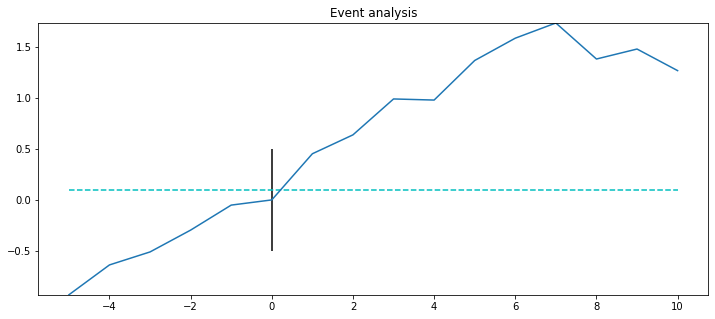

In [5]:
cu_event  = cu_data[['date','close','money']].set_index('date')
event_fn = lambda s: cu_event[cu_event['money'] ==0][s].index
event_df = get_event_perf(cu_event, event_fn, event_window=10)
# event_df = event_df.replace([np.inf, -np.inf], np.nan).dropna()
plot_event_analysis(event_df)

We suprisingly find that after the trading limit, there's increase within 10 lags and decrease within 5 lags, which means this phenomenon will happen around V shape. This is weird and inconsistent with our common sense. We hypothesize that it might because there are so many times that reached trading limit, and there would be many 0s, which will lead to bias. Thus, we decided to leave out the trading limit phenomenon and only focus on what some general 0s. 

In [392]:
cu_data.head()

,date,open,close,high,low,volume,money,open_interest
0,2005-01-04 09:01:00,29110,29080,29170,29080,3158,459908300,121604
1,2005-01-04 09:02:00,29080,29100,29100,29030,1970,286417600,121806
2,2005-01-04 09:03:00,29110,29060,29110,29060,1418,206240600,122000
3,2005-01-04 09:04:00,29060,29070,29080,29050,942,136908100,122024
4,2005-01-04 09:05:00,29080,29070,29090,29060,1134,164892800,122198


In [449]:
# # a = minute5_close.ta.percent_return().reset_index()['PCTRET_1']

# cu_close  = cu_data[['date','close']].set_index('date')
# minute5_close = cu_close.resample('5min').mean().dropna()

# ## get the 5 minutes frequency mean close price return
# # close_ret5m = minute5_close.ta.percent_return()
# # close_ret5m.describe()

# len(minute5_close)

233099

### The 5-minute close price return exploration

In [8]:
## get 5 minutes frequency mean close price
cu_close  = cu_data[['date','close']].set_index('date')
minute5_close = cu_close.resample('5min',how = 'mean').dropna()

## get the 5 minutes frequency mean close price return
close_ret5m = minute5_close.ta.percent_return()
close_ret5m.describe()

count    233098.000000
mean          0.000004
std           0.001780
min          -0.061084
25%          -0.000382
50%           0.000000
75%           0.000391
max           0.066349
Name: PCTRET_1, dtype: float64

We can see that the 25%, 50%, 75% are 0, which means the mean of close return of 5 minutes might converge into 0 in long run.

In [12]:
## rename 
close_ret5m = pd.DataFrame(close_ret5m).rename(columns={'PCTRET_1':'close_return'}).dropna()
close_ret5m.head()

,close_return
date,
2005-01-04 09:05:00,-0.002734
2005-01-04 09:10:00,0.000828
2005-01-04 09:15:00,0.001654
2005-01-04 09:20:00,0.001514
2005-01-04 09:25:00,-0.000481


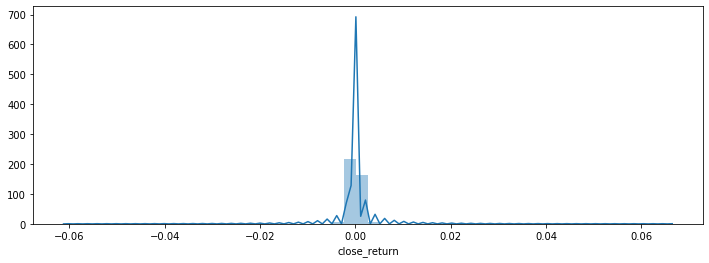

In [13]:
## plot distribution of 5 minutes close price return
fig,axes = plt.subplots(figsize=(12,4), squeeze=False)
sns.distplot(close_ret5m['close_return'])

In [14]:
## getting new format of index
close_ret5m_new = close_ret5m.set_index(close_ret5m.index.map(lambda x: int(x.time().strftime('%H%M'))))
close_ret5m_new.head()

,close_return
date,
905,-0.002734
910,0.000828
915,0.001654
920,0.001514
925,-0.000481


In [15]:
## get morning period 5 minutes close mean return 
morn_ret5m = close_ret5m_new[close_ret5m_new.index.map(lambda x: x in range(900,1131))].dropna()
morn_ret5m_grouped  = morn_ret5m.groupby(morn_ret5m.index).mean()

## get afternoon period 5 minutes close mean return 
noon_ret5m = close_ret5m_new[close_ret5m_new.index.map(lambda x: x in range(1330,1501))].dropna()
noon_ret5m_grouped  = noon_ret5m.groupby(noon_ret5m.index).mean()

## get night period 5 minutes close mean return 
night_ret5m = close_ret5m_new[close_ret5m_new.index.map(lambda x: x in range(2100,2400) or x in range(0,101))].dropna()
night_ret5m_grouped = night_ret5m.groupby(night_ret5m.index).mean()

In [16]:
# adjusitng the date for night data.
night_ret5m_grouped['date1'] = night_ret5m_grouped.index
night_ret5m_grouped['date1'][0:12] = night_ret5m_grouped['date1'][0:12] + 2400
night_ret5m_grouped['date1'][100] = 2460
night_ret5m_grouped.sort_values(by='date1')
night_ret5m_grouped.head()

,close_return,date1
date,,
0,-7.563201e-07,2400
5,-2.979509e-06,2405
10,-2.187541e-05,2410
15,2.062571e-07,2415
20,-4.569695e-06,2420


Text(0.5, 1.0, '5 mins night period')

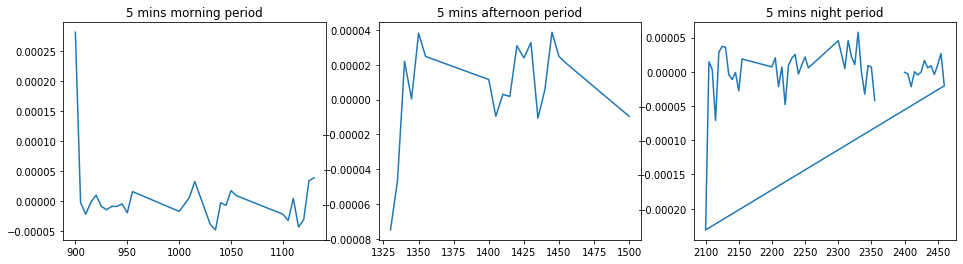

In [17]:
## compare 3 periods 
fig, axes = plt.subplots(1,3, figsize=(16,4), squeeze = False)
axes[0,0].plot(morn_ret5m_grouped)
axes[0,0].set_title('5 mins morning period')

axes[0,1].plot(noon_ret5m_grouped)
axes[0,1].set_title('5 mins afternoon period')

axes[0,2].plot(night_ret5m_grouped['date1'],night_ret5m_grouped['close_return'])
axes[0,2].set_title('5 mins night period')

From the graph, we can see that the morning time period starts from a high value, ends at a low value, while for both afternoon and night periods, it's the opposite way. Also, we can find especailly in afternoon and night period graphs that a raise usually followed by a raise; a decrease usually follwed by a decrease. We need to see that if there is any pattern in other period levels(10mins, monthly). 

### The 10-minute close price return exploration

In [19]:
## get 10 minutes frequency mean close price
cu_close  = cu_data[['date','close']].set_index('date')
minute10_close = cu_close.resample('10min',how = 'mean').dropna()

## get the 10 minutes frequency mean close price return
close_ret10m = minute10_close.ta.percent_return()
close_ret10m.describe()

count    120724.000000
mean          0.000007
std           0.002452
min          -0.060161
25%          -0.000523
50%           0.000000
75%           0.000543
max           0.065677
Name: PCTRET_1, dtype: float64

In [20]:
## rename 
close_ret10m = pd.DataFrame(close_ret10m).rename(columns={'PCTRET_1':'close_return'}).dropna()
close_ret10m.head()

,close_return
date,
2005-01-04 09:10:00,0.000436
2005-01-04 09:20:00,0.002100
2005-01-04 09:30:00,-0.001340
2005-01-04 09:40:00,0.000860
2005-01-04 09:50:00,-0.000687


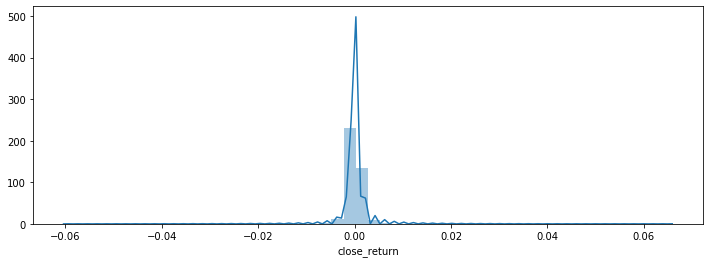

In [21]:
## plot distribution of 10 minutes close price return
fig,axes = plt.subplots(figsize=(12,4), squeeze=False)
sns.distplot(close_ret10m['close_return'])

In [22]:
## getting new format of index for eaiser plotting
close_ret10m_new = close_ret10m.set_index(close_ret10m.index.map(lambda x: int(x.time().strftime('%H%M'))))
close_ret10m_new.head()

,close_return
date,
910,0.000436
920,0.002100
930,-0.001340
940,0.000860
950,-0.000687


In [23]:
## get morning period 10 minutes close mean return 
morn_ret10m = close_ret10m_new[close_ret10m_new.index.map(lambda x: x in range(900,1131))].dropna()
morn_ret10m_grouped  = morn_ret10m.groupby(morn_ret10m.index).mean()

## get afternoon period 10 minutes close mean return 
noon_ret10m = close_ret10m_new[close_ret10m_new.index.map(lambda x: x in range(1330,1501))].dropna()
noon_ret10m_grouped  = noon_ret10m.groupby(noon_ret10m.index).mean()

## get night period 10 minutes close mean return 
night_ret10m = close_ret10m_new[close_ret10m_new.index.map(lambda x: x in range(2100,2400) or x in range(0,101))].dropna()
night_ret10m_grouped = night_ret10m.groupby(night_ret10m.index).mean()

In [24]:
# adjusitng the date for night data.
night_ret10m_grouped['date1'] = night_ret10m_grouped.index
night_ret10m_grouped['date1'][0:6] = night_ret10m_grouped['date1'][0:6] + 2400
night_ret10m_grouped['date1'][100] = 2460
night_ret10m_grouped.sort_values(by='date1')
night_ret10m_grouped.head()

,close_return,date1
date,,
0,-0.000023,2400
10,-0.000023,2410
20,-0.000005,2420
30,0.000019,2430
40,0.000010,2440


Text(0.5, 1.0, '10 mins night period')

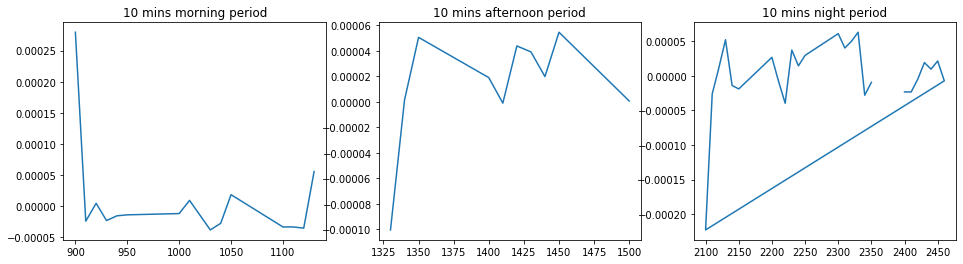

In [25]:
## compare 3 periods 
fig, axes = plt.subplots(1,3, figsize=(16,4), squeeze = False)
axes[0,0].plot(morn_ret10m_grouped)
axes[0,0].set_title('10 mins morning period')

axes[0,1].plot(noon_ret10m_grouped)
axes[0,1].set_title('10 mins afternoon period')

axes[0,2].plot(night_ret10m_grouped['date1'],night_ret10m_grouped['close_return'])
axes[0,2].set_title('10 mins night period')

From the graph, we can see that, the conclusion is similar to that of 5 minutes

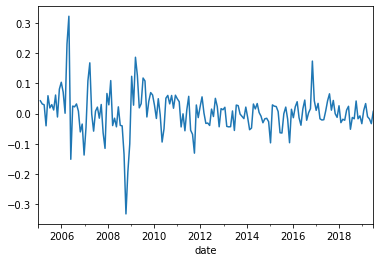

In [26]:
cu_close.resample('30D', how='mean').ta.percent_return().plot()

## Analysis
1. time series AR(1), AR(2)
2. holiday analysis, after and before holiday, price, amount. (holiday lists)(how about friday and monday?)
3. compare different time/trading period, morning, afternoon, as well as friday nights, any significant difference?
4. index analysis, MACD,DMA,CR?? there are so many indexs, which one should I choose?
5. period analysis 1 min, 2 mins, 5 mins, 10 mins? which period has the highest profits interval?

### Time Series Analysis

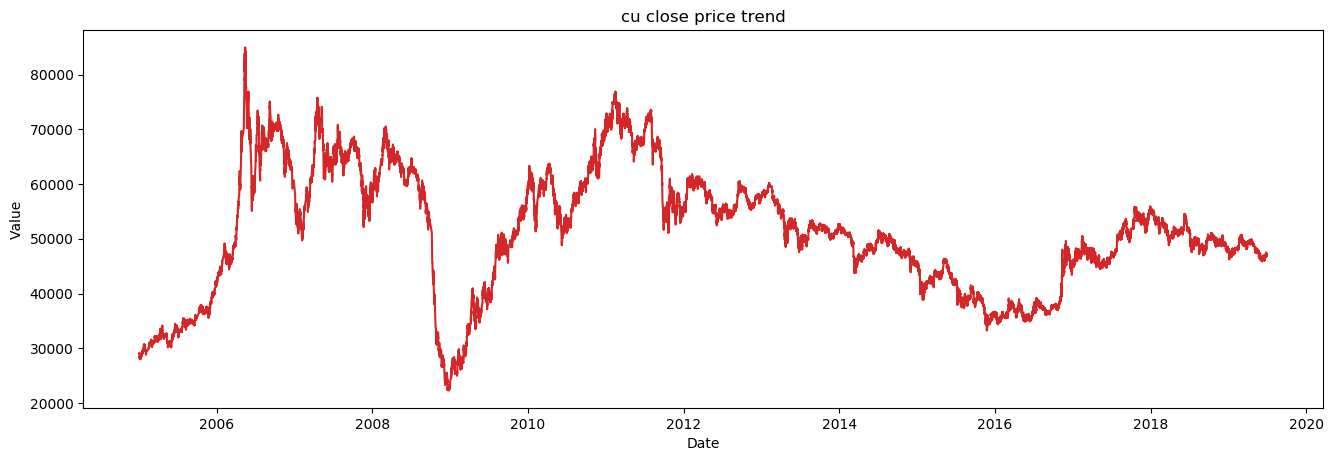

In [27]:
# Draw Plot of cu close price trend
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(cu_data[['date','close']], x=cu_data[['date']], y=cu_data[['close']],\
        title='cu close price trend') 

From the graph, we can know that there seems to be stochastic trend of cu close price, thus, we need to check and avoid this problem.

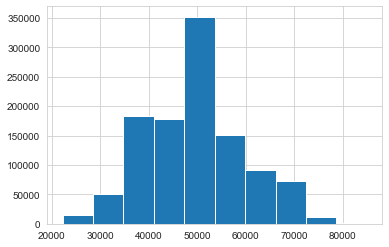

In [26]:
## check stationary & non-stationary
cu_data['close'].hist()
plt.show()

Running the example plots a histogram of values from the time series. We clearly see the bell curve-like shape of the Gaussian distribution, with a longer right tail.

In [27]:
## ADF test for close price
from statsmodels.tsa.stattools import adfuller
X = cu_data['close'][1000000:1100000]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.194410
p-value: 0.208280
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In summary, we can know that p-value is relatively high, thus, we failed to reject the null hypothesis and reach the conclusion that the close price has a unit root, which means it's non-stationary, thus we need to get the first diff of the close price.(ps: There are so many data, so we tried many different series of data and the reached conclusions are the same)

In [28]:
## get the price return(first diff) of close price
close_return = cu_data.ta.percent_return()
close_return.head()

0         NaN
1    0.000688
2   -0.001375
3    0.000344
4    0.000000
Name: PCTRET_1, dtype: float64

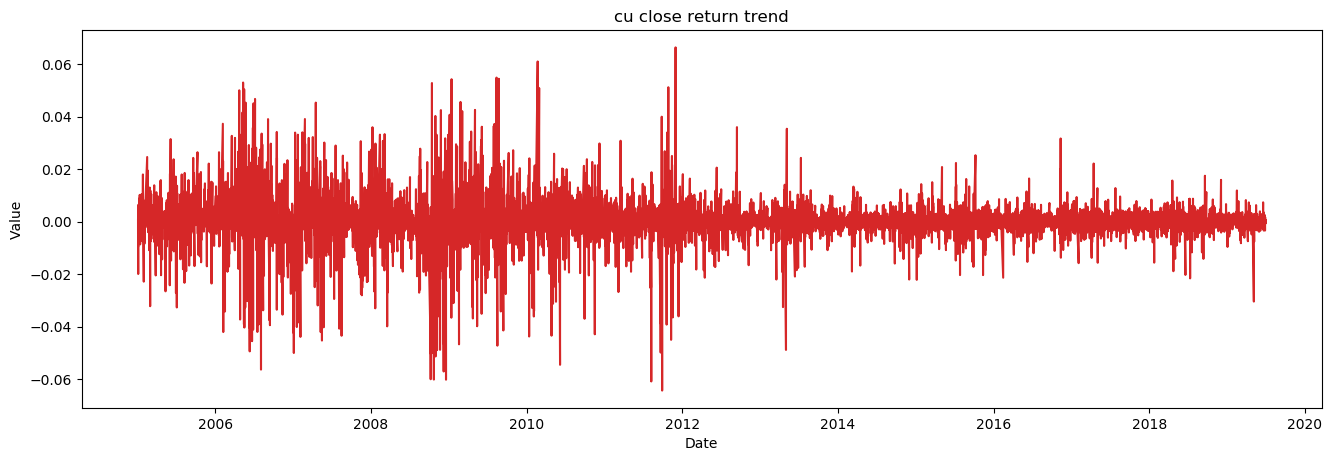

In [30]:
## draw plot of cu close return
df = close_return.copy()
df = pd.DataFrame(df).set_index(cu_data.date)
plot_df(df, x=df.index, y=df.ix[:,0:],\
        title='cu close return trend') 

### ARIMA Model

In [30]:
## ADF test for close return
X2 = close_return[100000:200000]
result_return = adfuller(X2)
print('ADF Statistic: %f' % result_return[0])
print('p-value: %f' % result_return[1])
print('Critical Values:')
for key, value in result_return[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -102.808200
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In summary, we can know that p-value is 0, thus, we reject the null hypothesis and reach the conclusion that the close return doesn't have a unit root, which means it's stationary. And we can use this data to do forecasting.(ps: There are so many data, so we tried many different series of data and the reached conclusions are the same!)

From above, we can decide to choose the first order differencing. d =1. And as for close return, it is stationary itself, we choose d=0.

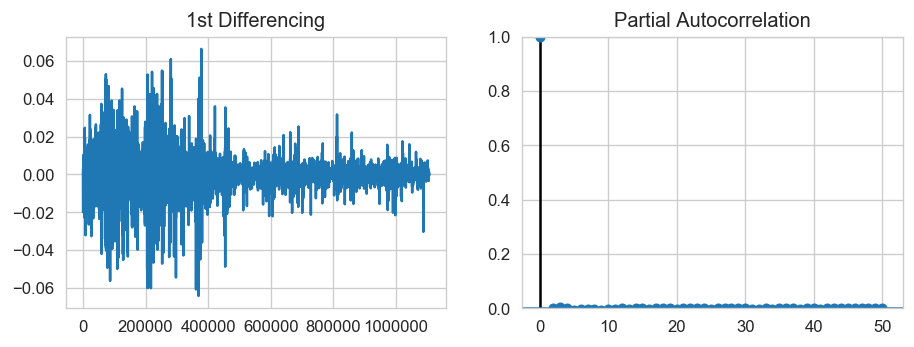

In [33]:
## Find AR term (p)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(close_return[1:]); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1))
plot_pacf(close_return[1:].tolist(), lags=50, ax=axes[1])

plt.show()

From the graph, we can hardly decide the p term; p=0 might be the best.

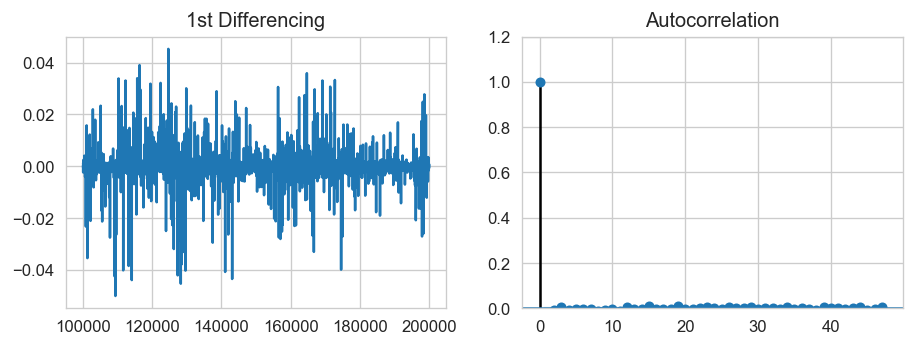

In [35]:
# ## Find MA term (q)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(close_return[100000:200000]); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(close_return[150000:200000].dropna(), ax=axes[1])

plt.show()

In [37]:
# Create Training
x = cu_close.resample('5min',how = 'mean').dropna().ta.percent_return().reset_index()['PCTRET_1'].dropna()
train1= x[1:233001]
train1 = train1.tolist()

Because the dataset is so large, we cannot run it at once, thus, we need to optimize the ARIMA model by ourselves. Here, we deciced to use every 500 data points to get the model of ARIMA, then use the obtained parameters to predict the following 500 data points with every point's neareast data.

#### Try ARIMA(1,0,0)

In [40]:
## define a new function for predicting for ARIMA(1,0,0)
def forecasting(train, steps=500):
    steps_x = steps
    predict =[]
    while steps_x<len(train):
        i = 0
        model = ARIMA(train[steps_x-500:steps_x], order=(1,0,0))
        model_fit = model.fit(disp=-1)
        while True:
            cur_predict =[]
            if i < 500:
                cur_predict.append(model_fit.params[0] +\
                                   model_fit.params[1]*train[steps_x])
                i += 1
                steps_x += 1
                predict.append(cur_predict)
            else:
                break
    return predict                
# + model_fit.params[2]*train[steps_x-1]
#                                   model_fit.params[3]*(train[steps_x+1]-(model_fit.params[0]

In [41]:
## predict using ARIMA(1,0,0)
forecast1 = forecasting(train1,steps=500)

In [42]:
## because we started our prediction from the 501th point, so we get our train series from 501th
train_series = train1[501:]

## because we don't use the prediction of last point to evaluate our result, so we leave out it
forecast1 = forecast1[:-1]

## put the forecast result into a list and then change it to a series
forecast1_series = []
for i in range(len(forecast1)):
    forecast1_series.append(forecast1[i][0])
forecast1_series = pd.Series(forecast1_series)

In [43]:
## evaluate our result based on the correlation between train and forecast
np.corrcoef(forecast1_series,train_series)

array([[1.        , 0.05077167],
       [0.05077167, 1.        ]])

The ARIMA(1,0,0) has  about 5.1% prediction power of 5-minute level close price return

#### Try ARIMA(2,0,0)

In [44]:
## define a new function for predicting for ARIMA(2,0,0)
def forecasting(train, steps=500):
    steps_x = steps
    predict =[]
    while steps_x<len(train):
        i = 0
        model = ARIMA(train[steps_x-500:steps_x], order=(2,0,0))
        model_fit = model.fit(disp=-1)
        while True:
            cur_predict =[]
            if i < 500:
                cur_predict.append(model_fit.params[0] +\
                                   model_fit.params[1]*train[steps_x] + model_fit.params[2]*train[steps_x-1])
                i += 1
                steps_x += 1
                predict.append(cur_predict)
            else:
                break
    return predict                

#                                   model_fit.params[3]*(train[steps_x+1]-(model_fit.params[0]

In [45]:
## predict using ARIMA(2,0,0)
forecast2 = forecasting(train1,steps=500)

In [46]:
## because we started our prediction from the 501th point, so we get our train series from 501th
train_series = train1[501:]

## because we don't use the prediction of last point to evaluate our result, so we leave out it
forecast2 = forecast2[:-1]

## put the forecast result into a list and then change it to a series
forecast2_series = []
for i in range(len(forecast2)):
    forecast2_series.append(forecast2[i][0])
forecast2_series = pd.Series(forecast2_series)

In [48]:
## evaluate our result based on the correlation between train and forecast
np.corrcoef(forecast2_series,train_series)

array([[1.        , 0.04909147],
       [0.04909147, 1.        ]])

The ARIMA(2,0,0) has  about 4.9% prediction power of 5-minute level close price return

#### Try ARIMA (2,0,1)

In [54]:
## define a new function for predicting for ARIMA(2,0,1)
def forecasting(train, steps=500):
    steps_x = steps
    predict =[]
    while steps_x<len(train):
        i = 0
        model = ARIMA(train[steps_x-500:steps_x], order=(2,0,1))
        model_fit = model.fit(disp=-1)
        while True:
            cur_predict =[]
            if i < 500:
                cur_predict.append(model_fit.params[0] +\
                                   model_fit.params[1]*train[steps_x] + model_fit.params[2]*train[steps_x-1]+\
                                     model_fit.params[3]*(train[steps_x]-(model_fit.params[0]+\
                                        model_fit.params[1]*train[steps_x-1]+model_fit.params[2]*train[steps_x-2])))
                i += 1
                steps_x += 1
                predict.append(cur_predict)
            else:
                break
    return predict                

In [55]:
## predict using ARIMA(2,0,1)
forecast3 = forecasting(train1,steps=500)

In [56]:
## because we started our prediction from the 501th point, so we get our train series from 501th
train_series = train1[501:]

## because we don't use the prediction of last point to evaluate our result, so we leave out it
forecast3 = forecast3[:-1]

## put the forecast result into a list and then change it to a series
forecast3_series = []
for i in range(len(forecast3)):
    forecast3_series.append(forecast3[i][0])
forecast3_series = pd.Series(forecast3_series)

In [57]:
## evaluate our result based on the correlation between train and forecast
np.corrcoef(forecast3_series,train_series)

array([[1.        , 0.00602693],
       [0.00602693, 1.        ]])

We can find that ARIMA(2,0,1) has a very weak power of predicting

#### In the end, we find that ARIMA(1,0,0) has the strongest power of predicting, and it can be new feature in the future predciting

## comparison with other futures
1. correlation analysis
2. crossover analysis

### loading other futures data

In [6]:
### 沪深300股指期货
path = '/Users/tjmask/Desktop/quantitative strategy/data/'
if_data = pd.read_csv(path+'IF9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
if_data.drop('Unnamed: 0', axis=1, inplace=True)
## 中证500股指期货
ic_data = pd.read_csv(path+'IC9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
ic_data.drop('Unnamed: 0', axis=1, inplace=True)
## 上证50股指期货
ih_data = pd.read_csv(path+'IH9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
ih_data.drop('Unnamed: 0', axis=1, inplace=True)
# ## 沪深300股指期权
# io_data = pd.read_csv(path+'IO9999.csv',
#                       infer_datetime_format=True,
#                       parse_dates=[1])
# io_data.drop('Unnamed: 0', axis=1, inplace=True)
## 2年国债期货
ts_data = pd.read_csv(path+'TS9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
ts_data.drop('Unnamed: 0', axis=1, inplace=True)
## 5年国债期货
tf_data = pd.read_csv(path+'TF9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
tf_data.drop('Unnamed: 0', axis=1, inplace=True)
## 10年国债期货
t_data = pd.read_csv(path+'T9999.csv',
                      infer_datetime_format=True,
                      parse_dates=[1])
t_data.drop('Unnamed: 0', axis=1, inplace=True)

print("Done!")

Done!


In [7]:
## look at the shape 
if_data.shape,ic_data.shape, ih_data.shape, ts_data.shape, tf_data.shape,t_data.shape, cu_data.shape

((578250, 8),
 (251280, 8),
 (251280, 8),
 (55890, 8),
 (381510, 8),
 (281610, 8),
 (1106130, 8))

### high frequency price return correlation(1min, 5mins, 10mins, 30mins, 60mins)

In [9]:
## get the close price return
cu_fdp = pd.DataFrame(cu_data.ta.percent_return())
cu_fdp.columns = ['cu_return']
cu_fdp = cu_fdp.set_index(cu_data.date)

if_fdp = pd.DataFrame(if_data.ta.percent_return())
if_fdp.columns = ['if_return']
if_fdp =  if_fdp.set_index(if_data.date)

ic_fdp = pd.DataFrame(ic_data.ta.percent_return())
ic_fdp.columns = ['ic_return']
ic_fdp =  ic_fdp.set_index(ic_data.date)

ih_fdp = pd.DataFrame(ih_data.ta.percent_return())
ih_fdp.columns = ['ih_return']
ih_fdp =  ih_fdp.set_index(ih_data.date)

ts_fdp = pd.DataFrame(ts_data.ta.percent_return())
ts_fdp.columns = ['ts_return']
ts_fdp =  ts_fdp.set_index(ts_data.date)

tf_fdp = pd.DataFrame(tf_data.ta.percent_return())
tf_fdp.columns = ['tf_return']
tf_fdp =  tf_fdp.set_index(tf_data.date)

t_fdp = pd.DataFrame(t_data.ta.percent_return())
t_fdp.columns = ['t_return']
t_fdp =  t_fdp.set_index(t_data.date)
t_fdp.head()

,t_return
date,
2015-03-23 09:16:00,NaN
2015-03-23 09:17:00,0.0
2015-03-23 09:18:00,0.0
2015-03-23 09:19:00,0.0
2015-03-23 09:20:00,0.0


#### merge close price return

In [10]:
## get merge data 
return_merge = pd.merge(cu_fdp, if_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, ic_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, ih_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, tf_fdp, how='inner', on = ['date'])
return_merge = pd.merge(return_merge, t_fdp, how='inner', on = ['date']).dropna()
return_merge.head()

,cu_return,if_return,ic_return,ih_return,tf_return,t_return
date,,,,,,
2015-04-17 09:17:00,-0.000229,0.001549,-0.001038,0.007145,0.000360,-0.000780
2015-04-17 09:18:00,0.000229,-0.001060,-0.000130,-0.001623,-0.000206,0.000416
2015-04-17 09:19:00,-0.000229,0.000265,-0.001740,0.001626,-0.000514,-0.000416
2015-04-17 09:20:00,0.000457,0.001017,0.001171,0.002164,0.000000,0.000156
2015-04-17 09:21:00,0.000000,0.000221,-0.000494,-0.000720,0.000000,0.000000


In our above merge data, we didn't merge ts_data, this is becasue, ts_data has way less data than other futures, thus, we need to find its correlation with other futures seperately.

In [17]:
## 1 minutes frequency
return_1min = return_merge.resample('1min', how ='mean').dropna()
## getting the correltation matrix
return_1min_mat = return_1min.corr()

## 5 minutes frequency
return_5min = return_merge.resample('5min', how ='mean').dropna()
## getting the correltation matrix
return_5min_mat = return_5min.corr()

## 10 minutes frequency
return_10min = return_merge.resample('10min', how ='mean').dropna()
## getting the correltation matrix
return_10min_mat = return_10min.corr()

## 30 minutes frequency
return_30min = return_merge.resample('30min', how ='mean').dropna()
## getting the correltation matrix
return_30min_mat = return_30min.corr()

## 60 minutes frequency
return_60min = return_merge.resample('60min', how ='mean').dropna()
## getting the correltation matrix
return_60min_mat = return_60min.corr()


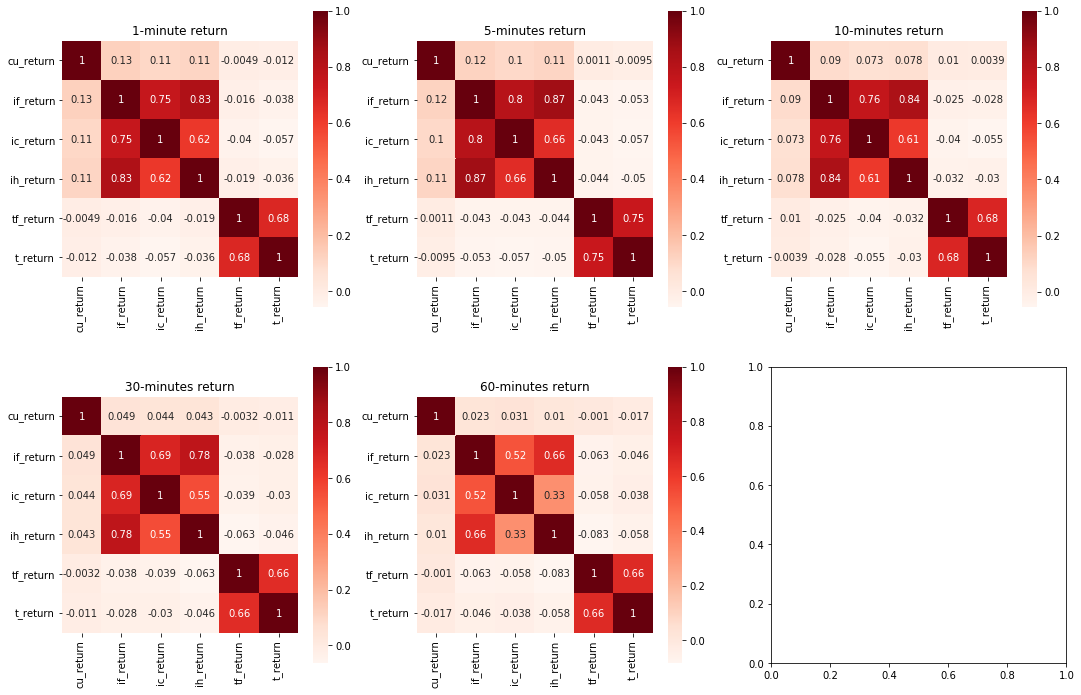

In [19]:
## heatmap for the those periods
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(18,12))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.ravel()

sns.heatmap(return_1min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax1)
ax1.set_title('1-minute return')
sns.heatmap(return_5min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax2)
ax2.set_title('5-minutes return')
sns.heatmap(return_10min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax3)
ax3.set_title('10-minutes return')
sns.heatmap(return_30min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax4)
ax4.set_title('30-minutes return')
sns.heatmap(return_60min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax5)
ax5.set_title('60-minutes return')
plt.show()

From the result above, we can see that, close price return of CU is decreasing as frequency goes down, we try to figure out if there are Hysteresis effect of price return.

### Hysteresis effect of price return

In [23]:
## 1 minute frequency
return_1m = return_merge.resample(rule = '1m', how ='mean').dropna()
## getting the correltation matrix
return_1m_mat = return_1m.corr()
## one period shift
shift1_1m  = return_1m.ix[:,1:].shift(1)
shift1_1m = pd.merge(return_1m['cu_return'], shift1_1m, how ='inner', on ='date').dropna()
shift1_1m_mat = shift1_1m.corr()

## 5 minutes frequency
return_5min = return_merge.resample('5min', how ='mean').dropna()
## getting the correltation matrix
return_5min_mat = return_5min.corr()
## one period shift
shift1_5m  = return_5min.ix[:,1:].shift(1)
shift1_5m = pd.merge(return_5min['cu_return'], shift1_5m, how ='inner', on ='date').dropna()
shift1_5m_mat = shift1_5m.corr()

## 10 minutes frequency
return_10min = return_merge.resample('10min', how ='mean').dropna()
## getting the correltation matrix
return_10min_mat = return_10min.corr()
## one period shift
shift1_10m  = return_10min.ix[:,1:].shift(1)
shift1_10m = pd.merge(return_10min['cu_return'], shift1_10m, how ='inner', on ='date').dropna()
shift1_10m_mat = shift1_10m.corr()

## 30 minutes frequency
return_30min = return_merge.resample('30min', how ='mean').dropna()
## getting the correltation matrix
return_30min_mat = return_30min.corr()
## one period shift
shift1_30m  = return_30min.ix[:,1:].shift(1)
shift1_30m = pd.merge(return_30min['cu_return'], shift1_30m, how ='inner', on ='date').dropna()
shift1_30m_mat = shift1_30m.corr()

## 60 minutes frequency
return_60min = return_merge.resample('60min', how ='mean').dropna()
## getting the correltation matrix
return_60min_mat = return_60min.corr()
## one period shift
shift1_60m  = return_60min.ix[:,1:].shift(1)
shift1_60m = pd.merge(return_60min['cu_return'], shift1_60m, how ='inner', on ='date').dropna()
shift1_60m_mat = shift1_60m.corr()

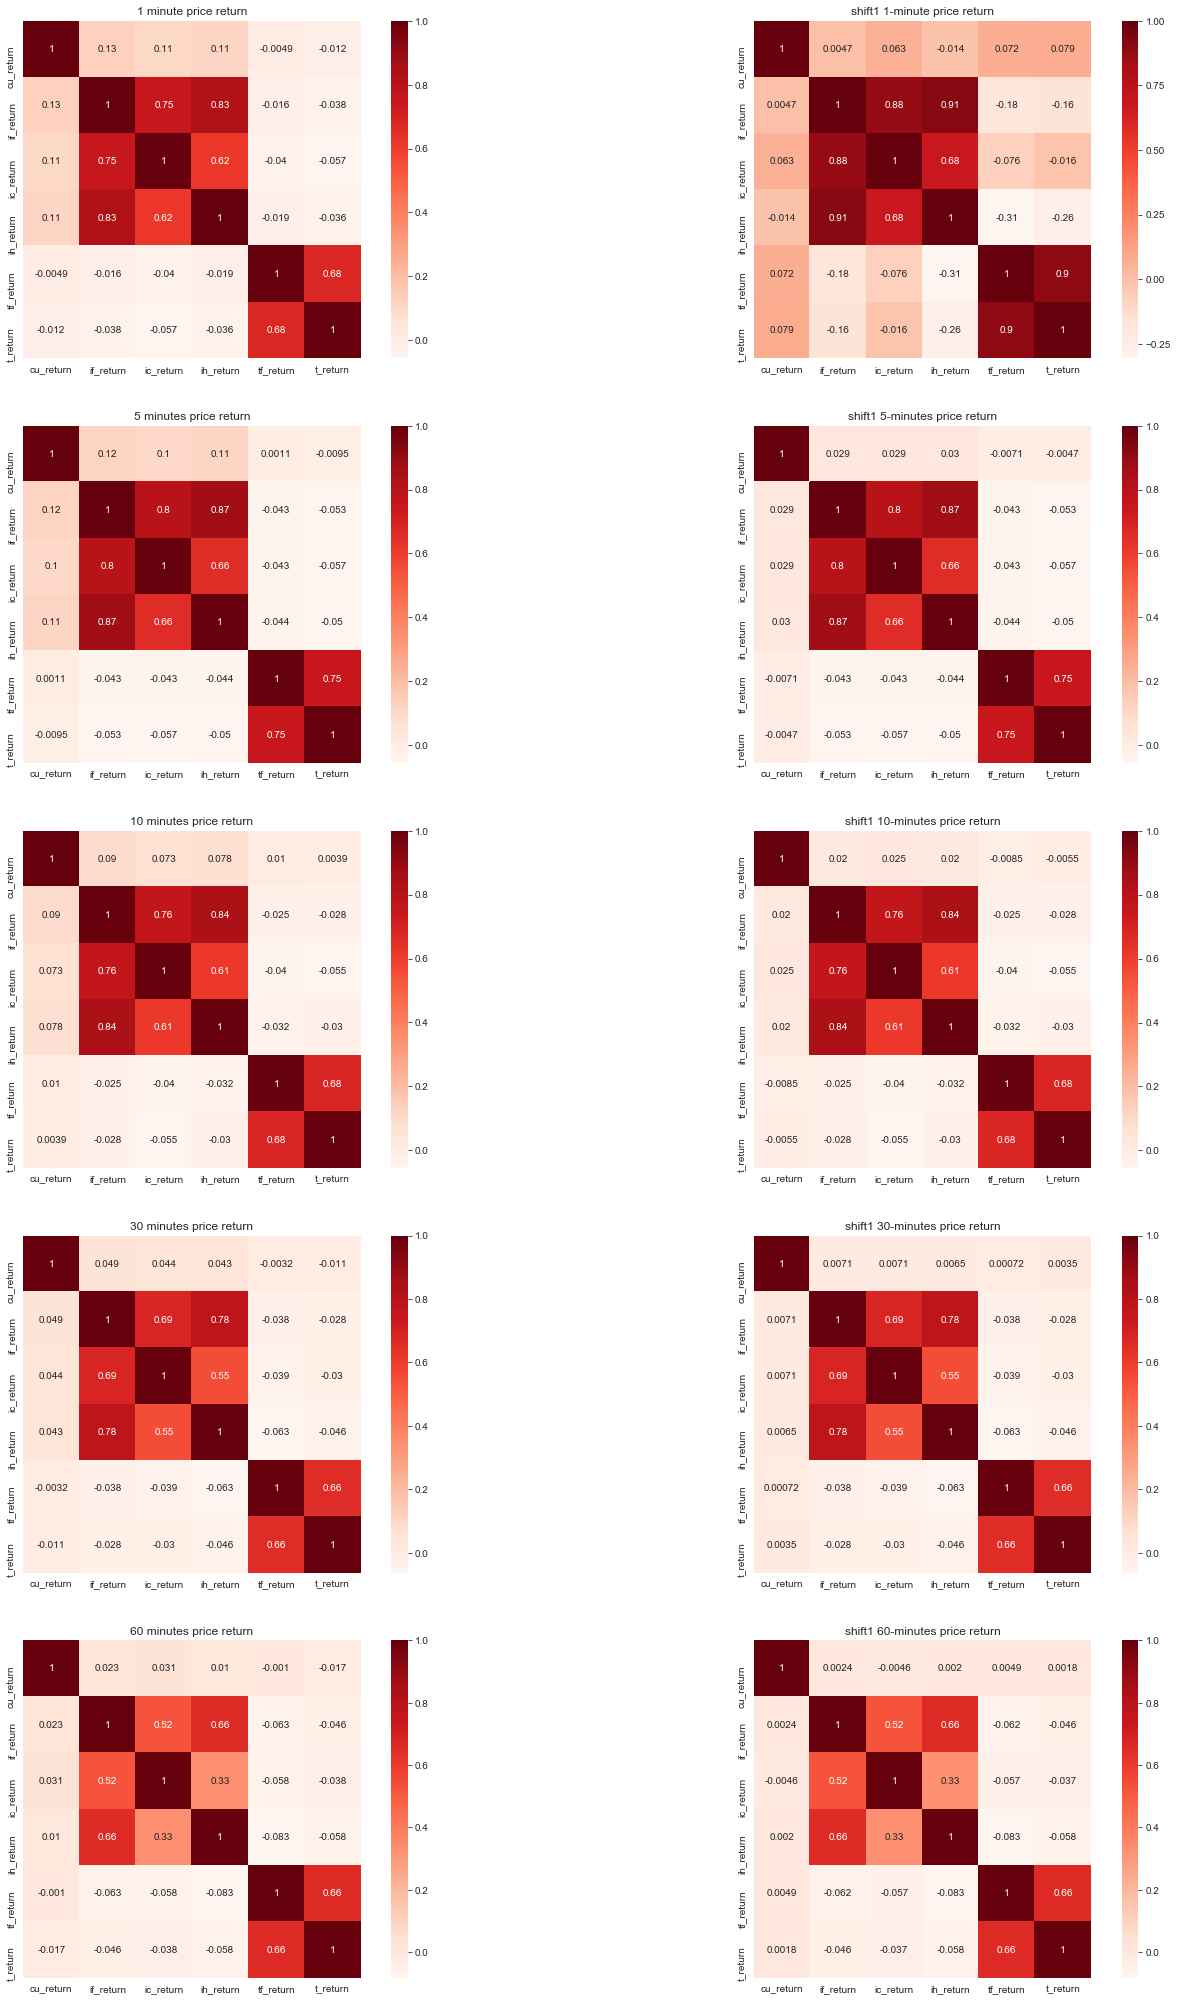

In [209]:
## heatmap for the those periods
fig,axes=plt.subplots(nrows=5,ncols=2,figsize=(24,36))
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10 = axes.ravel()

sns.heatmap(return_1min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax1)
ax1.set_title('1 minute price return')
sns.heatmap(shift1_1m_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax2)
ax2.set_title('shift1 1-minute price return')

sns.heatmap(return_5min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax3)
ax3.set_title('5 minutes price return')
sns.heatmap(shift1_5m_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax4)
ax4.set_title('shift1 5-minutes price return')

sns.heatmap(return_10min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax5)
ax5.set_title('10 minutes price return')
sns.heatmap(shift1_10m_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax6)
ax6.set_title('shift1 10-minutes price return')

sns.heatmap(return_30min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax7)
ax7.set_title('30 minutes price return')
sns.heatmap(shift1_30m_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax8)
ax8.set_title('shift1 30-minutes price return')

sns.heatmap(return_60min_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax9)
ax9.set_title('60 minutes price return')
sns.heatmap(shift1_60m_mat, annot=True, vmax=1, square=True, cmap='Reds', ax=ax10)
ax10.set_title('shift1 60-minutes price return')

plt.show()

From the result, we can see that, on 5 minute level, the hysteresis effects of other futures is the relatively high, this can be a feature of predicting the price return of CU.

### Analysis of ts_data seperately

In [31]:
## get merge data seperately with TS close return
# TS and CU
ts_cu = pd.merge(ts_fdp, cu_fdp, how='inner', on = ['date'])

# TS and IF
ts_if = pd.merge(ts_fdp, if_fdp, how='inner', on = ['date'])

# TS and IC
ts_ic = pd.merge(ts_fdp, ic_fdp, how='inner', on = ['date'])

# TS and IH
ts_ih = pd.merge(ts_fdp, ih_fdp, how='inner', on = ['date'])

# TS and TF
ts_tf = pd.merge(ts_fdp, tf_fdp, how='inner', on = ['date'])

# TS and T
ts_t = pd.merge(ts_fdp, t_fdp, how='inner', on = ['date'])
ts_t.head()

,ts_return,t_return
date,,
2018-08-20 09:16:00,NaN,-0.000106
2018-08-20 09:17:00,0.000353,0.000688
2018-08-20 09:18:00,0.000555,0.000106
2018-08-20 09:19:00,0.000050,0.000053
2018-08-20 09:20:00,-0.000202,0.000053


### 5 minutes frequency 

In [32]:
## 5 minutes frequency of each futures with cu
# TS & CU 
ts_cu_5 = ts_cu.resample('5min', how ='mean').dropna()
## getting the correltation matrix
ts_cu_mat5 = ts_cu_5.corr()
print(ts_cu_mat5)

# TS & IF
ts_if_5 = ts_if.resample('5min', how ='mean').dropna()
## getting the correltation matrix
ts_if_mat5 = ts_if_5.corr()
print(ts_if_mat5)

# TS & IC
ts_ic_5 = ts_ic.resample('5min', how ='mean').dropna()
## getting the correltation matrix
ts_ic_mat5 = ts_ic_5.corr()
print(ts_ic_mat5)

# TS & IH
ts_ih_5 = ts_ih.resample('5min', how ='mean').dropna()
## getting the correltation matrix
ts_ih_mat5 = ts_ih_5.corr()
print(ts_ih_mat5)

# TS & TF
ts_tf_5 = ts_tf.resample('5min', how ='mean').dropna()
## getting the correltation matrix
ts_tf_mat5 = ts_tf_5.corr()
print(ts_tf_mat5)

# CU & T
ts_t_5 = ts_t.resample('5min', how ='mean').dropna()
## getting the correltation matrix
ts_t_mat5 = ts_t_5.corr()
print(ts_t_mat5)

           ts_return  cu_return
ts_return    1.00000   -0.02523
cu_return   -0.02523    1.00000
           ts_return  if_return
ts_return   1.000000  -0.033731
if_return  -0.033731   1.000000
           ts_return  ic_return
ts_return   1.000000  -0.029434
ic_return  -0.029434   1.000000
           ts_return  ih_return
ts_return   1.000000  -0.028001
ih_return  -0.028001   1.000000
           ts_return  tf_return
ts_return   1.000000   0.183535
tf_return   0.183535   1.000000
           ts_return  t_return
ts_return   1.000000  0.181827
t_return    0.181827  1.000000


In [55]:
correlations = [1, -0.02523, -0.02523, -0.029434, -0.028001, 0.183535, 0.181827]
names = ['ts_return', 'cu_return', 'if_return', 'ic_return', 'ih_return','tf_return', 't_return']
matrix_all = pd.DataFrame([correlations], columns=names, index=['ts_return'])
matrix_all

,ts_return,cu_return,if_return,ic_return,ih_return,tf_return,t_return
ts_return,1,-0.02523,-0.02523,-0.029434,-0.028001,0.183535,0.181827


#### Hysteresis effect 

In [56]:
## 5 minutes frequency
## one period shift
shift1_cu_ts_5m  = ts_cu_5.ix[:,1:].shift(1)
shift1_cu_ts_5m = pd.merge(shift1_cu_ts_5m, ts_cu_5['ts_return'], how ='inner', on ='date').dropna()
shift1_cu_ts_5m_mat = shift1_cu_ts_5m.corr()
shift1_cu_ts_5m_mat

,cu_return,ts_return
cu_return,1.000000,-0.011196
ts_return,-0.011196,1.000000


Text(0.5, 1, '5-minute TS price correlations')

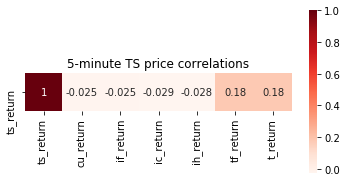

In [57]:
fig,axes=plt.subplots(figsize=(6,3))
ax1= axes
sns.heatmap(matrix_all, annot=True, vmax=1, square=True, cmap='Reds',ax=ax1)
ax1.set_title('5-minute TS price correlations')

From the result, we can see that TS has little hysteresis effect on CU at 5 minute level.

## Statistical Analysis

In this part, we will explore statistical features of CU

### time bucket(30mins 1 hour)

In [58]:
cu_data.head()

,date,open,close,high,low,volume,money,open_interest
0,2005-01-04 09:01:00,29110,29080,29170,29080,3158,459908300,121604
1,2005-01-04 09:02:00,29080,29100,29100,29030,1970,286417600,121806
2,2005-01-04 09:03:00,29110,29060,29110,29060,1418,206240600,122000
3,2005-01-04 09:04:00,29060,29070,29080,29050,942,136908100,122024
4,2005-01-04 09:05:00,29080,29070,29090,29060,1134,164892800,122198


#### 30 minutes level 

In [413]:
## get the mean of every column except 'volume'
cu_30m = cu_data.set_index('date').resample('30min', how='mean')
cu_30m['volume'] = cu_data[['date', 'volume']].set_index('date').resample('30min', how='sum')

## 30 minute level of close price return
close_return = pd.DataFrame(cu_data.ta.percent_return()).set_index(cu_data.date)
close_return.columns = ['close_return']
close_return_30m = close_return.resample(rule='30min', how='mean')

## add the close return to the cu_30m data frame
cu_30m['close_return'] = close_return_30m['close_return']

## add the weekday and time of each row
cu_30m['is_weekday'] = cu_30m.index.map(lambda x: datetime.date.isoweekday(x))
cu_30m['time'] = cu_30m.index.map(lambda x: x.time())
cu_30m.tail()

,open,close,high,low,volume,money,open_interest,close_return,is_weekday,time
date,,,,,,,,,,
2019-06-28 23:00:00,47060.000000,47059.000000,47065.000000,47053.333333,4000,3.137548e+07,221836.4,-0.000057,5,23:00:00
2019-06-28 23:30:00,47044.666667,47045.000000,47052.000000,47037.333333,3650,2.861495e+07,221472.0,0.000035,5,23:30:00
2019-06-29 00:00:00,47090.333333,47089.333333,47093.333333,47085.333333,2364,1.855505e+07,220650.4,0.000021,6,00:00:00
2019-06-29 00:30:00,47056.333333,47054.666667,47061.333333,47051.000000,1972,1.546531e+07,220359.4,-0.000050,6,00:30:00
2019-06-29 01:00:00,47050.000000,47020.000000,47060.000000,47020.000000,376,8.843360e+07,219970.0,-0.000425,6,01:00:00


In [137]:
## group by weekday 
weekly_30m = cu_30m.groupby(['time','is_weekday']).mean().dropna()
weekly_30m =  weekly_30m.reset_index(['time'])
weekly_30m.head()

,time,open,close,high,low,volume,money,open_interest,close_return
is_weekday,,,,,,,,,
2,00:00:00,45700.332056,45700.301405,45708.204342,45692.342273,2221.345695,4.768007e+07,242245.675096,-0.000003
3,00:00:00,45639.760843,45639.876084,45648.882280,45630.895911,3031.478836,6.264874e+07,242796.502850,0.000002
4,00:00:00,45722.255930,45722.484395,45731.511860,45713.189763,3213.894180,6.760597e+07,242054.093633,0.000004
5,00:00:00,45753.020202,45752.832071,45761.829545,45743.976010,2918.103175,6.177435e+07,241911.151515,-0.000003
6,00:00:00,45829.674797,45829.481030,45838.991870,45820.279133,2943.201058,6.685599e+07,241321.721409,-0.000004


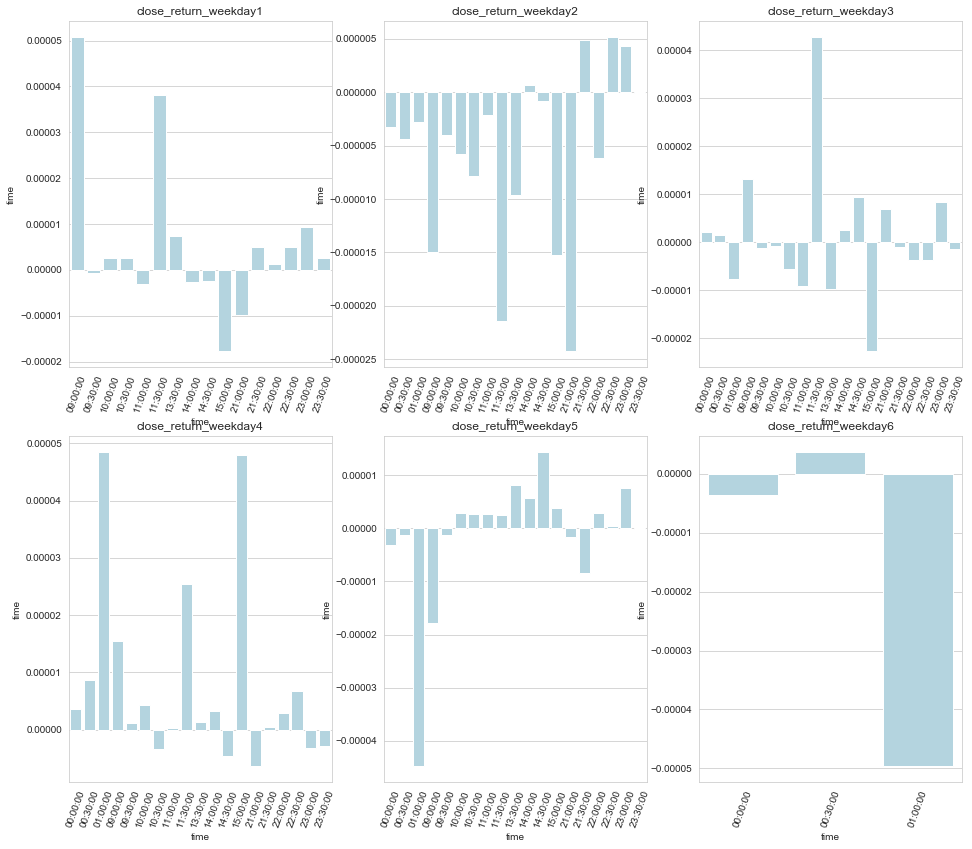

In [180]:
## plotting for bucket and weekdays
fig, axes = plt.subplots(2,3, figsize=(16,14), squeeze = False)
# i = weekly_30m.loc[(slice(None),2),:]
for i in range(6):
    x = weekly_30m[weekly_30m.index==i+1]['time']
    y = weekly_30m[weekly_30m.index==i+1]['close_return']
    ax = axes[i//3, i%3]
    sns.barplot(x=x,y=y, ax=ax,color = 'lightblue')
    sns.set_style("whitegrid")
    ax.set_title('close_return_weekday'+str(i+1))
    ax.set_ylabel("return")
    ax.set_ylabel("time")
    ax.set_xticklabels(x, rotation=70)

From the graph above, we can find that, we can make money if we going short on Tuseday and going long on Thursday. However, this conclusion is kind of skeptical. This might be caused by unbalanced slicing. We need to double check.

### Find if there are partterns of different buckets vary from time(year+month)

#### 30 mins level

In [414]:
### find if there are parttern vary from time(year+month)
# add columns of year+month
cu_30m['year_month'] = cu_30m.index.map(lambda x: 1000*x.year + x.month)
cu_30m.head() 

,open,close,high,low,volume,money,open_interest,close_return,is_weekday,time,year_month
date,,,,,,,,,,,
2005-01-04 09:00:00,29063.448276,29063.103448,29081.034483,29045.862069,28062,1.405622e+08,121751.724138,0.000013,2,09:00:00,2005001
2005-01-04 09:30:00,29077.000000,29078.000000,29086.000000,29068.333333,7982,3.867461e+07,122223.800000,-0.000011,2,09:30:00,2005001
2005-01-04 10:00:00,29088.125000,29086.250000,29096.250000,29080.000000,3588,3.261212e+07,122133.750000,-0.000021,2,10:00:00,2005001
2005-01-04 10:30:00,29086.896552,29089.310345,29092.758621,29083.103448,4242,2.127329e+07,122259.448276,0.000047,2,10:30:00,2005001
2005-01-04 11:00:00,29161.666667,29163.000000,29169.000000,29156.666667,8930,4.340151e+07,123273.866667,0.000069,2,11:00:00,2005001


In [416]:
## group by weekday 
year_month_30m = cu_30m.groupby(['time','year_month']).mean().dropna()
year_month_30m =  year_month_30m.reset_index(['time'])
len(year_month_30m)

2343

In [459]:
## add month to year_month_30m
year_month_30m['month'] = year_month_30m.index.map(lambda x: x%1000)
year_month_30m['year'] = year_month_30m.index.map(lambda x: x//1000)
year_month_30m.head()

,time,open,close,high,low,volume,money,open_interest,close_return,is_weekday,month,year
year_month,,,,,,,,,,,,
2013012,00:00:00,51959.714286,51959.380952,51965.761905,51953.571429,976.774194,3.750779e+07,223887.457143,-0.000010,3.935484,12,2013
2014001,00:00:00,51547.700000,51548.416667,51556.516667,51540.250000,4629.870968,6.161086e+07,229969.843333,0.000012,4.000000,1,2014
2014002,00:00:00,50395.711111,50396.311111,50402.555556,50390.000000,2860.500000,4.456982e+07,229841.742222,0.000014,4.000000,2,2014
2014003,00:00:00,46264.714286,46264.174603,46279.365079,46250.047619,19993.419355,2.223343e+08,351386.336508,-0.000010,4.064516,3,2014
2014004,00:00:00,46783.883333,46783.700000,46790.100000,46777.950000,4620.533333,5.390350e+07,303679.853333,0.000004,3.900000,4,2014


In [463]:
year_month_30m['time'].describe()

count         2343
unique          19
top       11:00:00
freq           174
Name: time, dtype: object

In [482]:
temp = year_month_30m[year_month_30m['year']==2018].groupby(['time','month', 'year']).mean()
temp = temp.reset_index(['year', 'month'])
temp.head()

,month,year,open,close,high,low,volume,money,open_interest,close_return,is_weekday
time,,,,,,,,,,,
00:00:00,1,2018,54058.396825,54058.492063,54068.015873,54049.301587,4790.193548,6.350175e+07,223116.009524,0.000016,3.806452
00:00:00,2,2018,52727.666667,52728.119048,52738.214286,52716.880952,3380.857143,5.914235e+07,222379.852381,0.000005,4.000000
00:00:00,3,2018,51318.449275,51319.405797,51328.898551,51308.840580,5093.806452,5.873308e+07,282924.860870,0.000015,4.096774
00:00:00,4,2018,51078.083333,51077.729167,51085.354167,51070.895833,1842.466667,2.945800e+07,234770.087500,-0.000010,4.000000
00:00:00,5,2018,51285.222222,51285.301587,51291.825397,51278.523810,3096.193548,3.901643e+07,205624.187302,-0.000003,3.903226


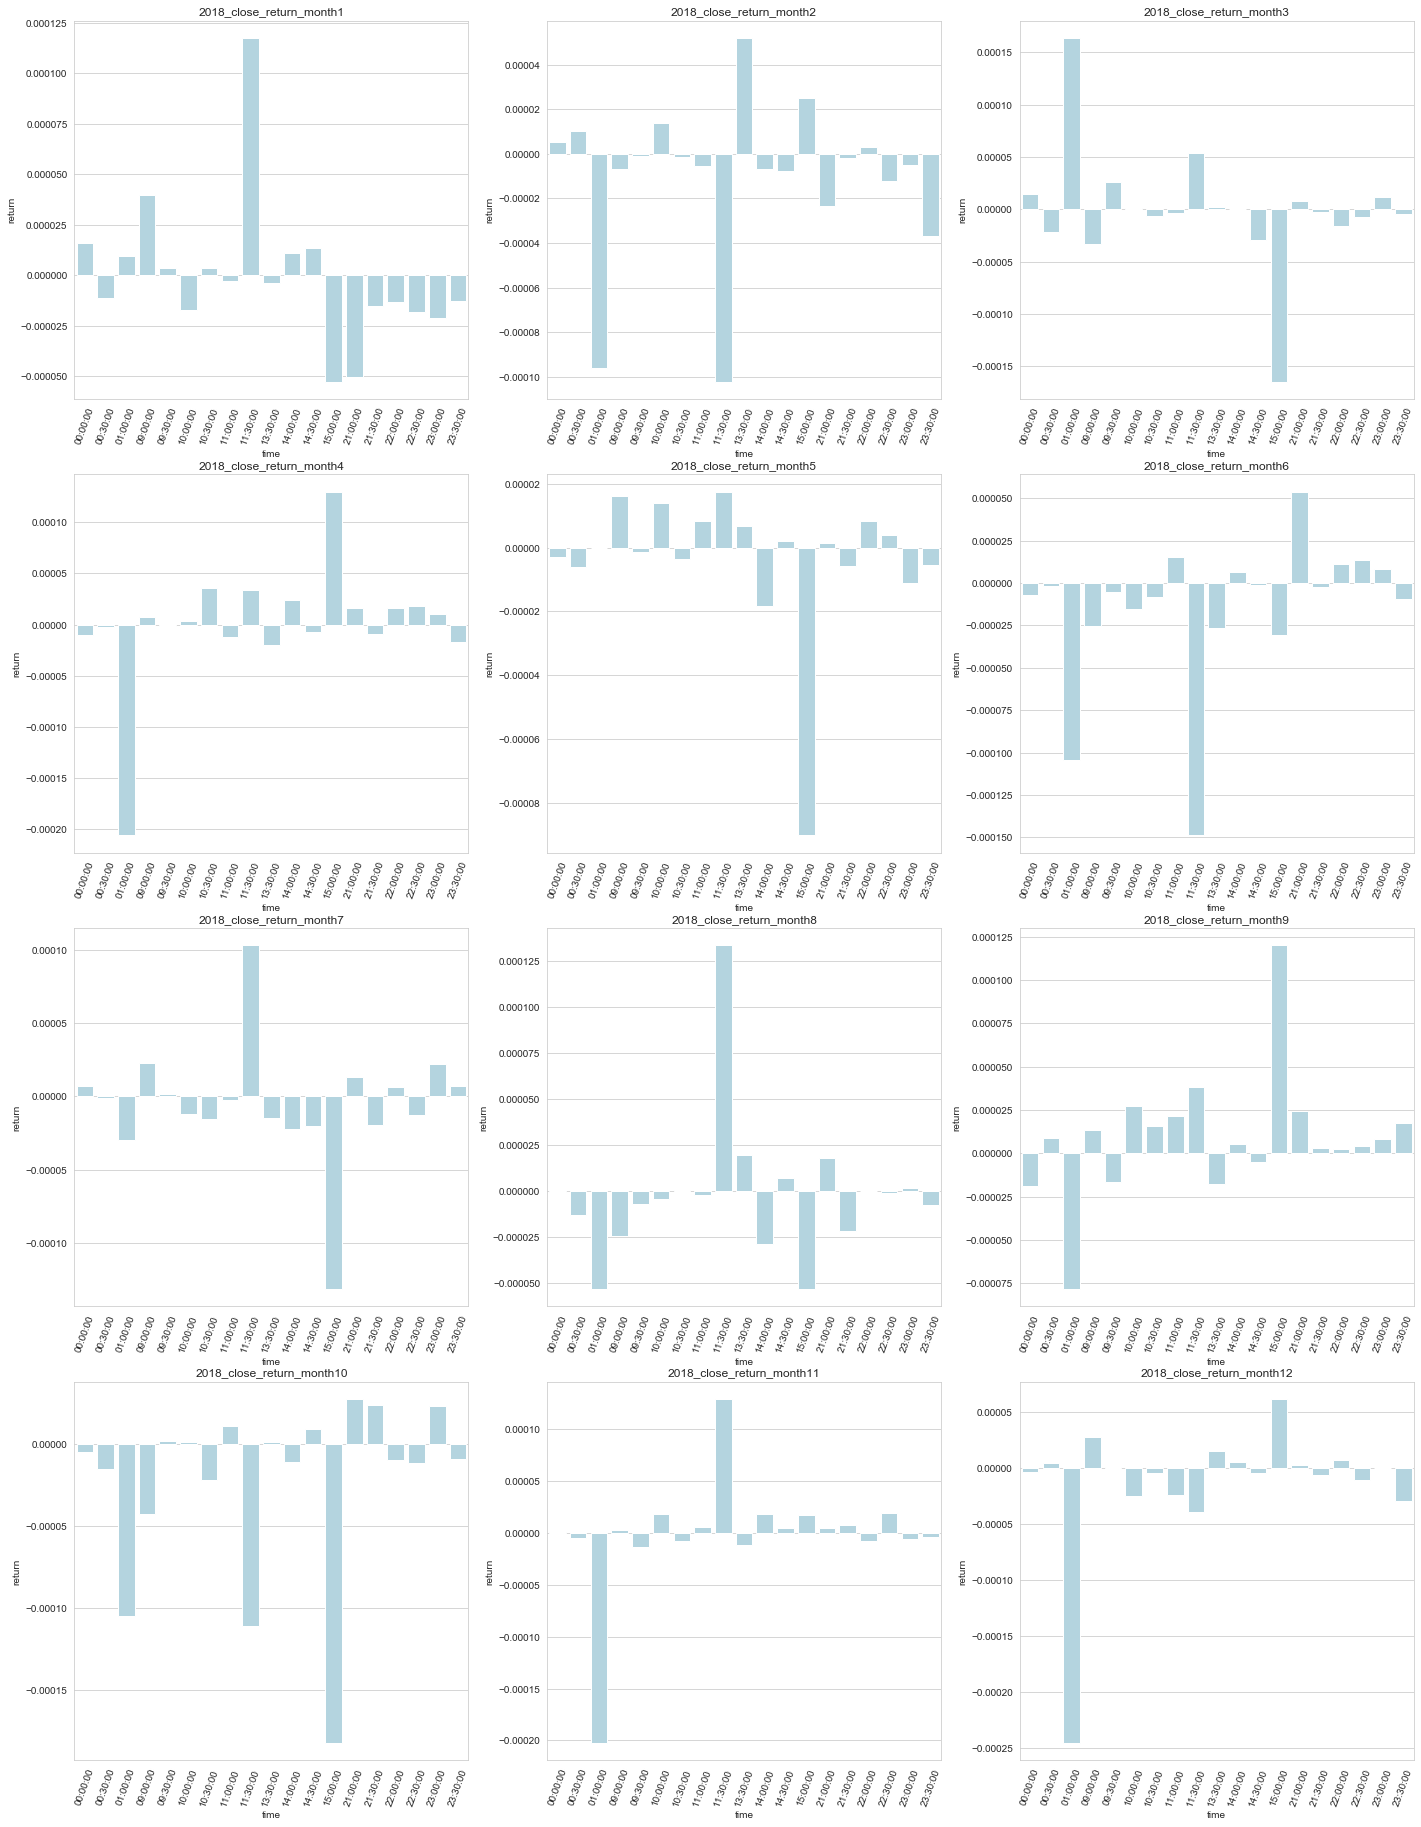

In [476]:
## plotting for bucket and weekdays
fig, axes = plt.subplots(4,3, figsize=(24,32), squeeze = False)
# i = weekly_30m.loc[(slice(None),2),:]
for i in range(12):
    temp = year_month_30m[year_month_30m['year']==2018].groupby(['time','month', 'year']).mean()
    temp = temp.reset_index(['month', 'year'])
    temp = temp[temp['month']==i+1]
    x = temp.index
    y = temp['close_return']
    ax = axes[i//3, i%3]
    sns.barplot(x=x,y=y, ax=ax,color = 'lightblue')
    sns.set_style("whitegrid")
    ax.set_title('2018_close_return_month'+str(i+1))
    ax.set_ylabel("return",)
    ax.set_xticklabels(x, rotation=70)

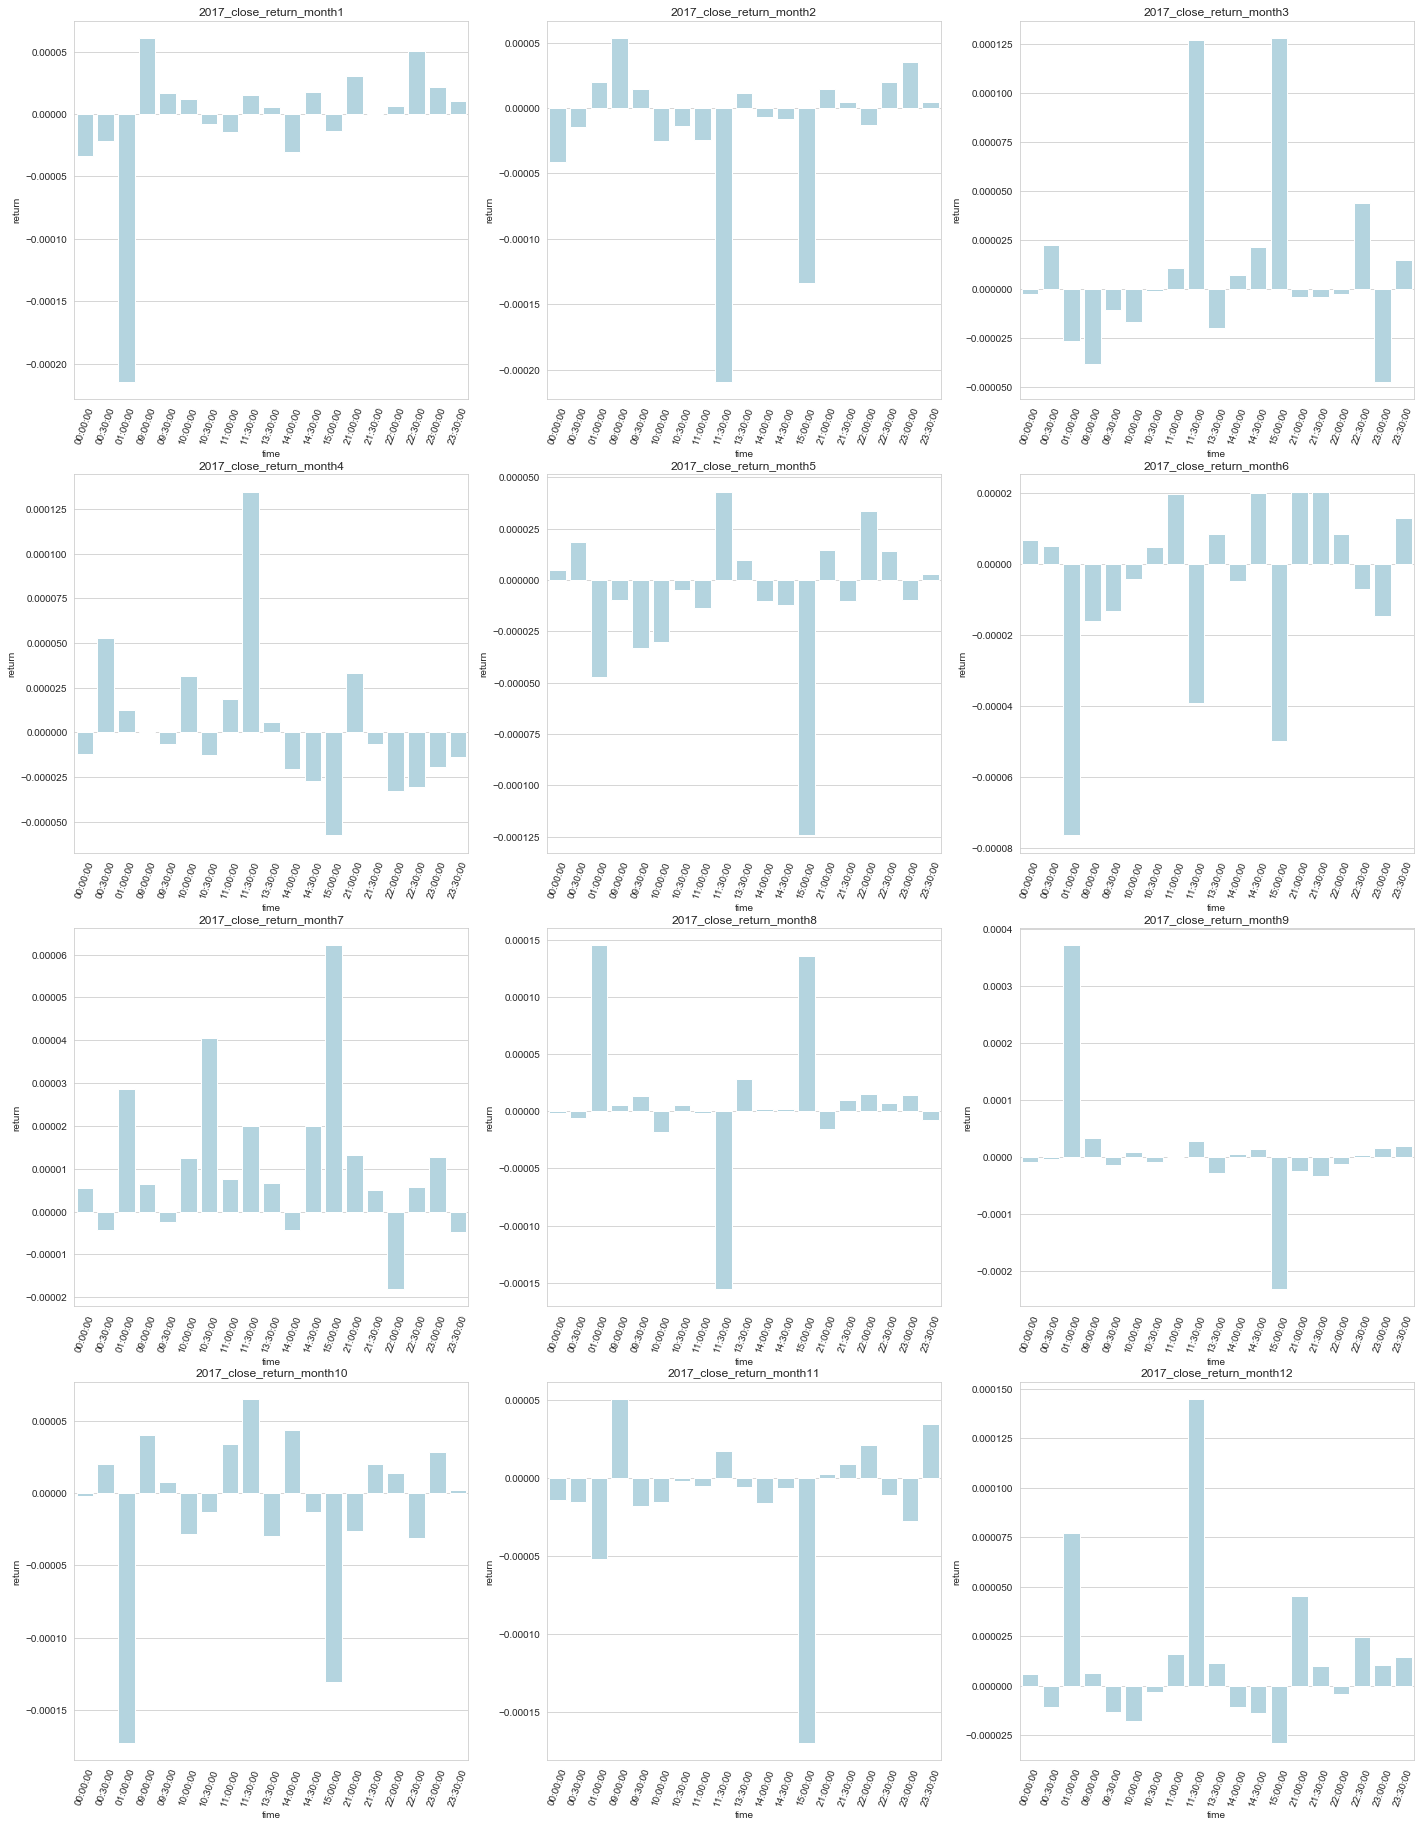

In [479]:
## plotting for bucket and weekdays
fig, axes = plt.subplots(4,3, figsize=(24,32), squeeze = False)
# i = weekly_30m.loc[(slice(None),2),:]
for i in range(12):
    temp = year_month_30m[year_month_30m['year']==2017].groupby(['time','month', 'year']).mean()
    temp = temp.reset_index(['month', 'year'])
    temp = temp[temp['month']==i+1]
    x = temp.index
    y = temp['close_return']
    ax = axes[i//3, i%3]
    sns.barplot(x=x,y=y, ax=ax,color = 'lightblue')
    sns.set_style("whitegrid")
    ax.set_title('2017_close_return_month'+str(i+1))
    ax.set_ylabel("return",)
    ax.set_xticklabels(x, rotation=70)

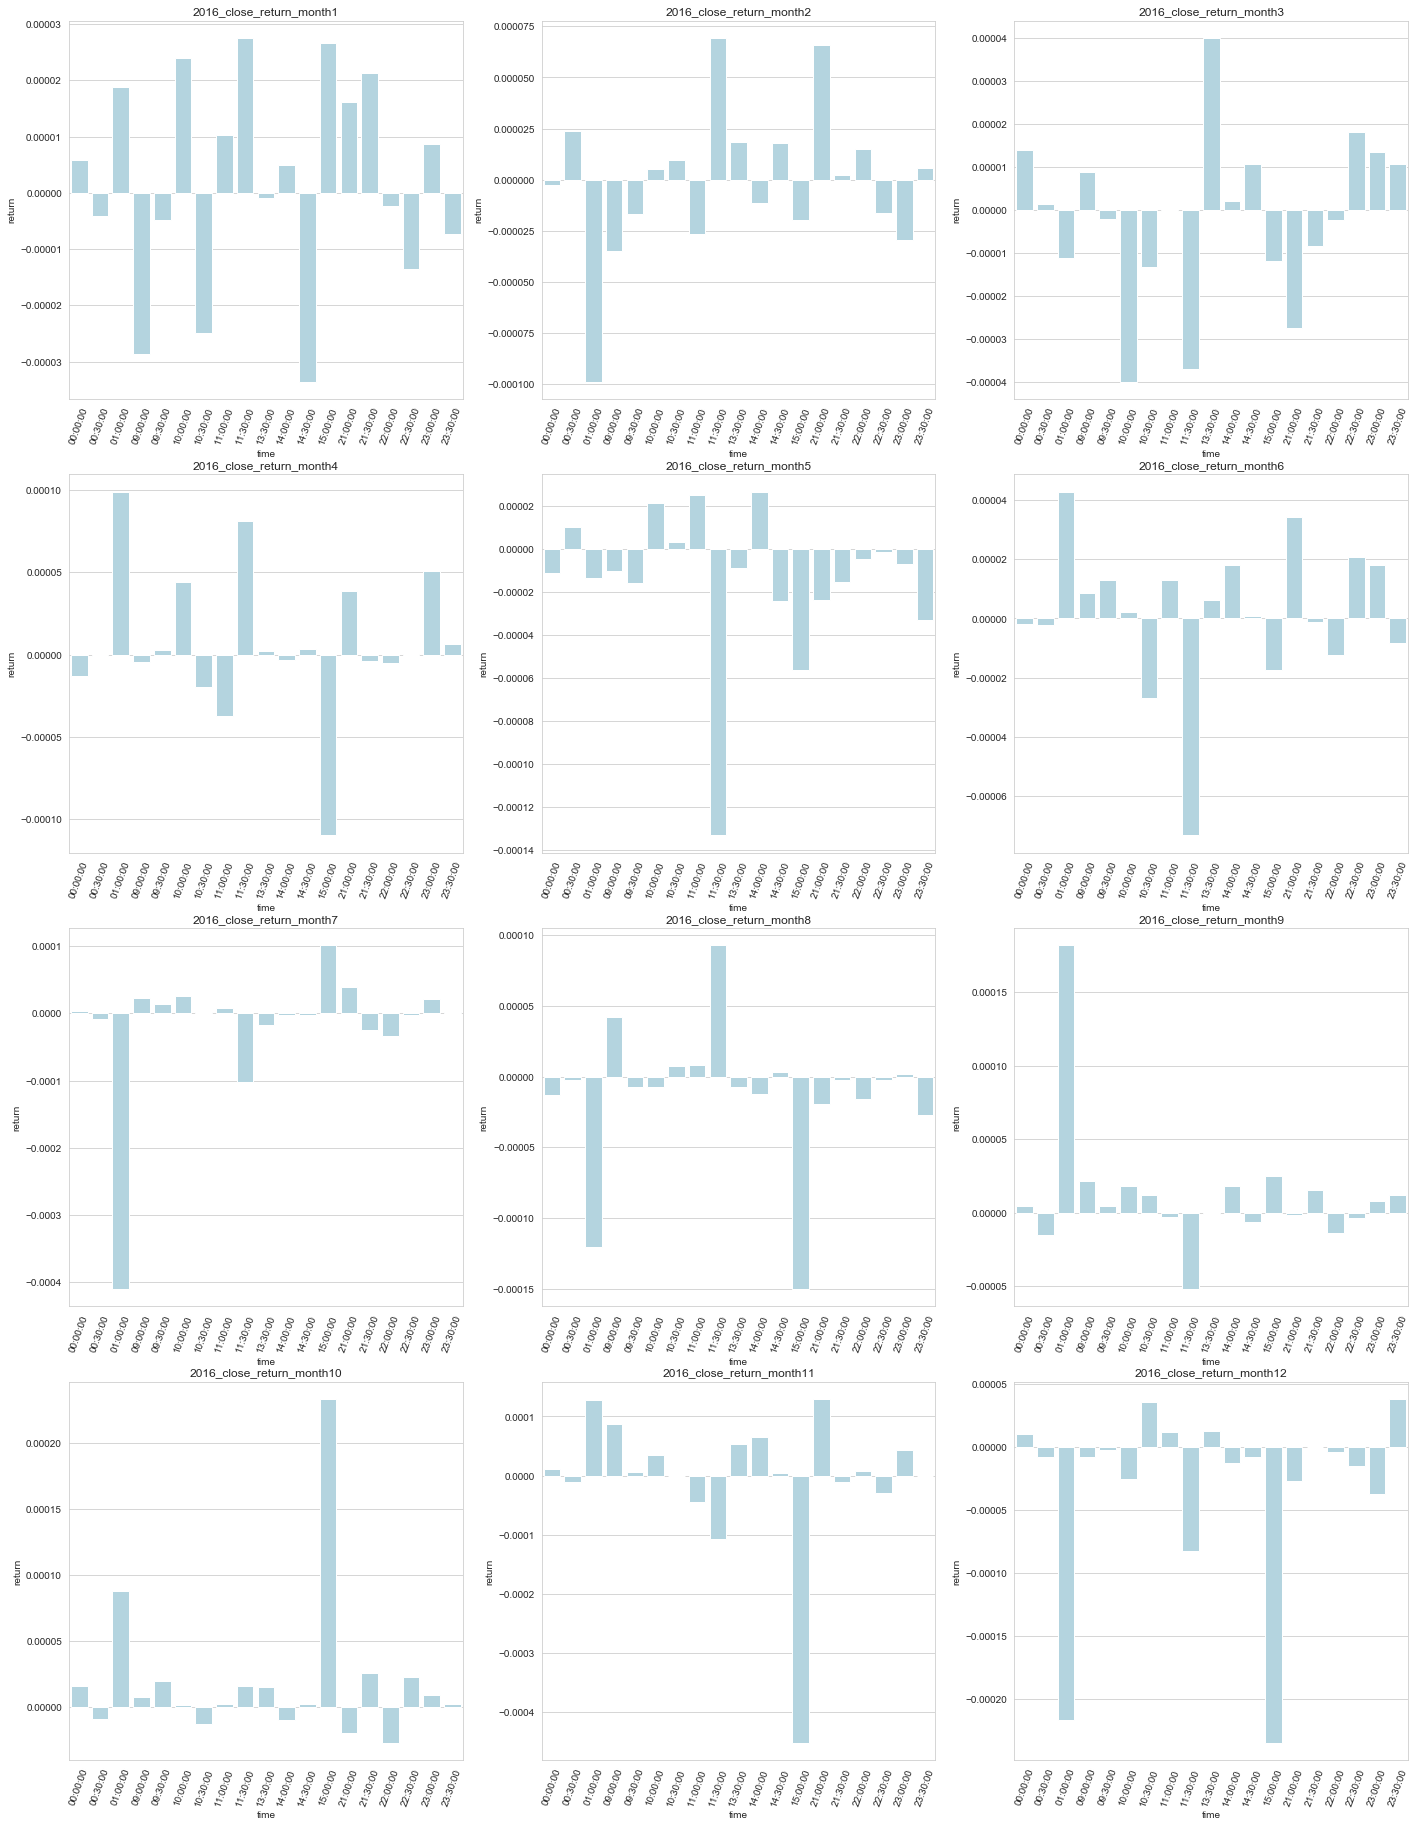

In [480]:
## plotting for bucket and weekdays
fig, axes = plt.subplots(4,3, figsize=(24,32), squeeze = False)
# i = weekly_30m.loc[(slice(None),2),:]
for i in range(12):
    temp = year_month_30m[year_month_30m['year']==2016].groupby(['time','month', 'year']).mean()
    temp = temp.reset_index(['month', 'year'])
    temp = temp[temp['month']==i+1]
    x = temp.index
    y = temp['close_return']
    ax = axes[i//3, i%3]
    sns.barplot(x=x,y=y, ax=ax,color = 'lightblue')
    sns.set_style("whitegrid")
    ax.set_title('2016_close_return_month'+str(i+1))
    ax.set_ylabel("return",)
    ax.set_xticklabels(x, rotation=70)

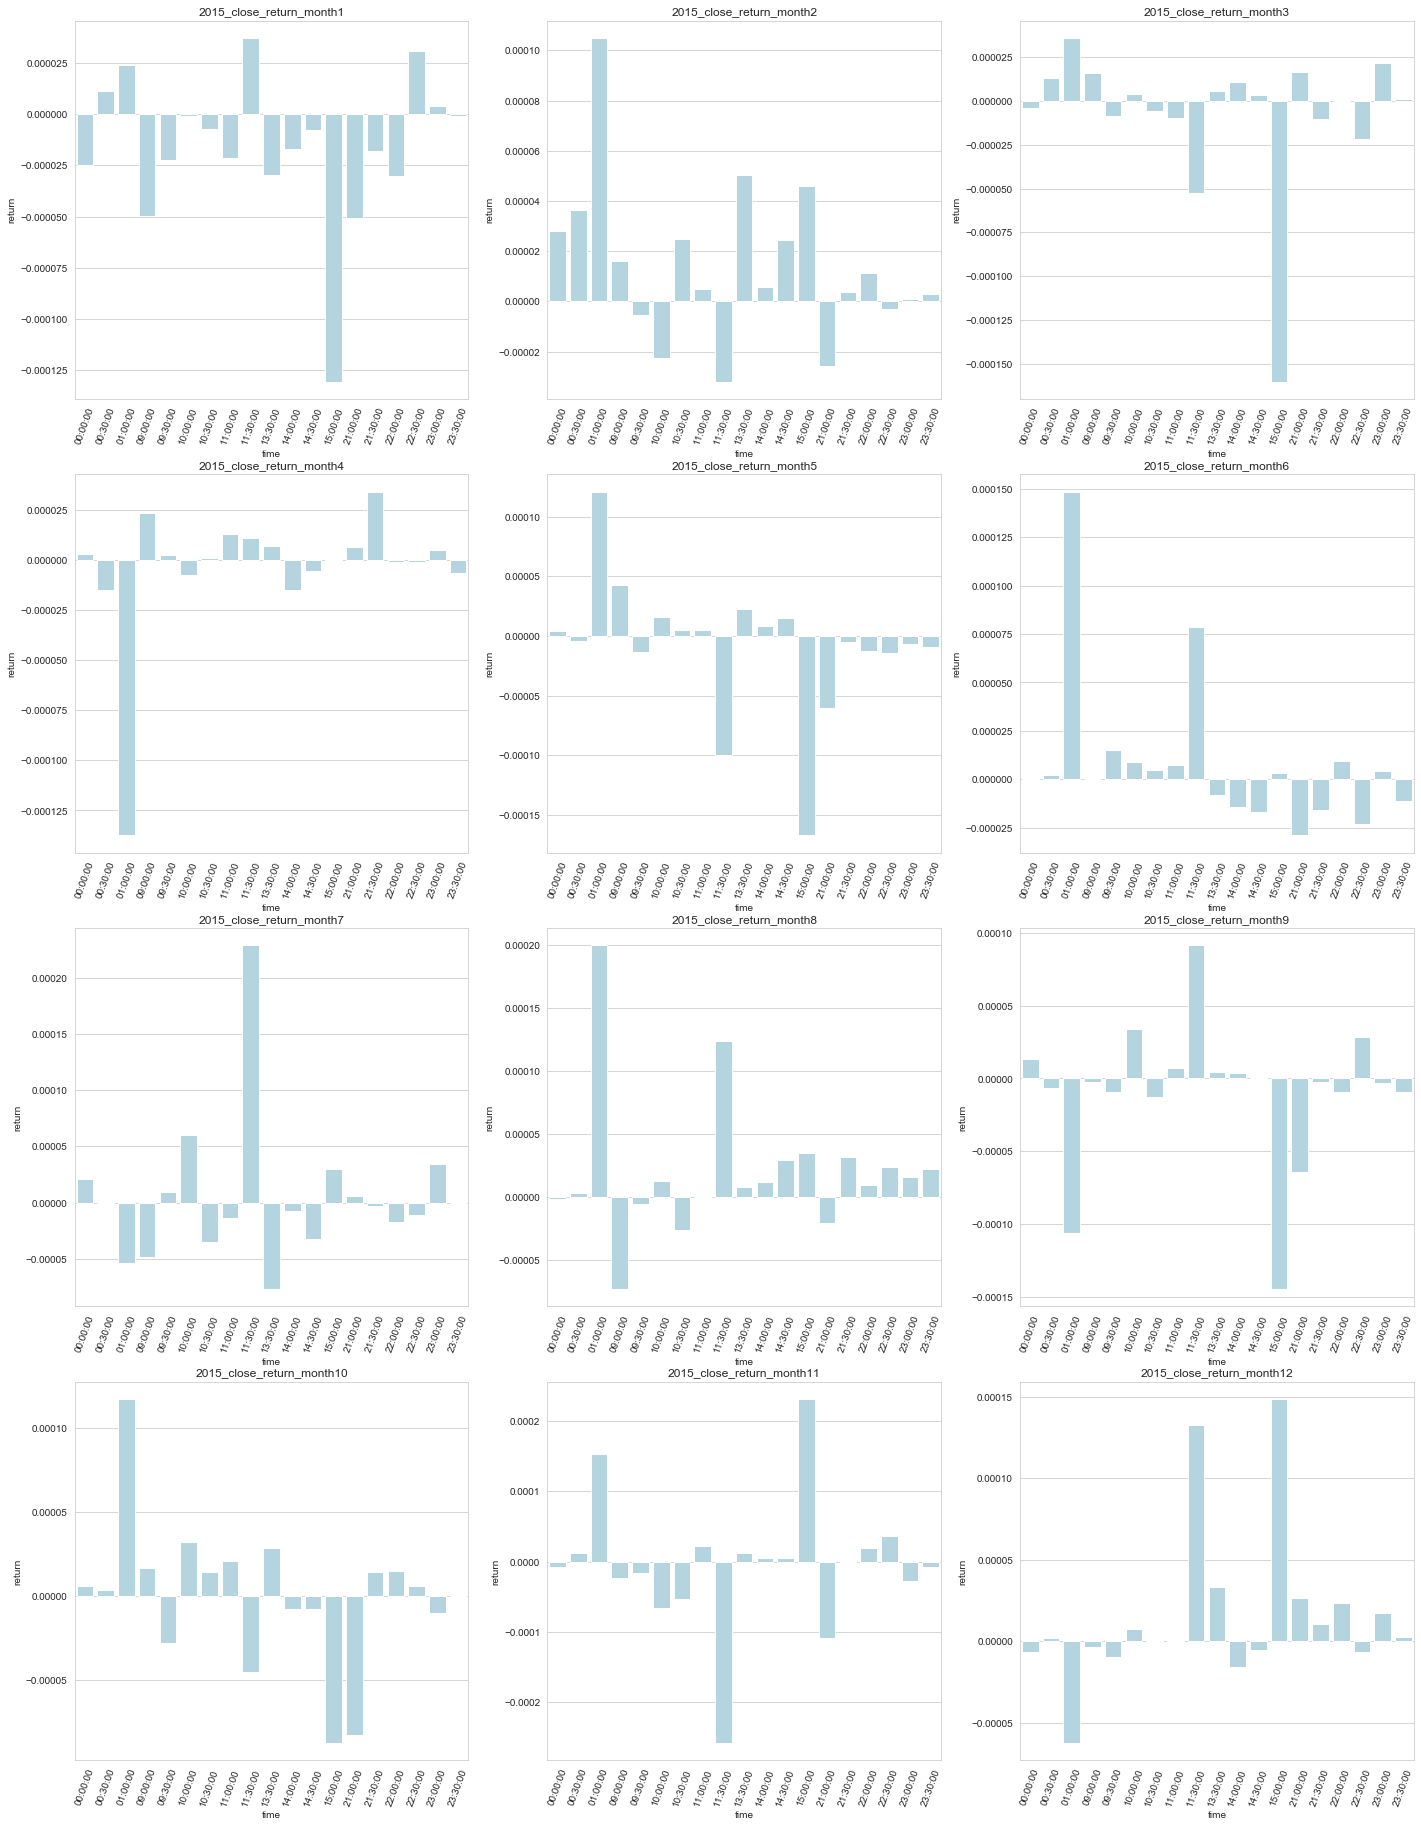

In [481]:
## plotting for bucket and weekdays
fig, axes = plt.subplots(4,3, figsize=(24,32), squeeze = False)
# i = weekly_30m.loc[(slice(None),2),:]
for i in range(12):
    temp = year_month_30m[year_month_30m['year']==2015].groupby(['time','month', 'year']).mean()
    temp = temp.reset_index(['month', 'year'])
    temp = temp[temp['month']==i+1]
    x = temp.index
    y = temp['close_return']
    ax = axes[i//3, i%3]
    sns.barplot(x=x,y=y, ax=ax,color = 'lightblue')
    sns.set_style("whitegrid")
    ax.set_title('2015_close_return_month'+str(i+1))
    ax.set_ylabel("return",)
    ax.set_xticklabels(x, rotation=70)

In [454]:
# ## plotting for bucket and weekdays
# fig, axes = plt.subplots(figsize=(12,10), squeeze = False)
# x = year_month_30m.index
# y = year_month_30m['time']
# sns.barplot(x=x,y=y,color = 'lightblue')
# sns.set_style("whitegrid")
# axes[0].set_title('close_return_weekday')
# axes[0].set_ylabel("return")
# axes.set_ylabel("time")
# axes.set_xticklabels(x, rotation=70)

#### 1 hour level

In [210]:
## get the mean of every column except 'volume'
cu_1h = cu_data.set_index('date').resample('60min', how='mean')
cu_1h['volume'] = cu_data[['date', 'volume']].set_index('date').resample('60min', how='sum')

## 1 hour level of close price return
close_return = pd.DataFrame(cu_data.ta.percent_return()).set_index(cu_data.date)
close_return.columns = ['close_return']
close_return_1h = close_return.resample(rule='60min', how='mean')

## add the close return to the cu_1h data frame
cu_1h['close_return'] = close_return_1h['close_return']

## add the weekday and time of each row
cu_1h['is_weekday'] = cu_1h.index.map(lambda x: datetime.date.isoweekday(x))
cu_1h['time'] = cu_1h.index.map(lambda x: x.time())
cu_1h.tail()

,open,close,high,low,volume,money,open_interest,close_return,is_weekday,time
date,,,,,,,,,,
2019-06-28 21:00:00,47058.813559,47058.305085,47064.406780,47052.203390,15836,6.314244e+07,221533.898305,0.000018,5,21:00:00
2019-06-28 22:00:00,47106.000000,47108.166667,47113.833333,47099.666667,11384,4.469851e+07,221532.500000,0.000018,5,22:00:00
2019-06-28 23:00:00,47052.333333,47052.000000,47058.500000,47045.333333,7650,2.999521e+07,221654.200000,-0.000011,5,23:00:00
2019-06-29 00:00:00,47073.333333,47072.000000,47077.333333,47068.166667,4336,1.701018e+07,220504.900000,-0.000014,6,00:00:00
2019-06-29 01:00:00,47050.000000,47020.000000,47060.000000,47020.000000,376,8.843360e+07,219970.000000,-0.000425,6,01:00:00


In [211]:
## group by weekday 
weekly_1h = cu_1h.groupby(['time','is_weekday']).mean().dropna()
weekly_1h =  weekly_1h.reset_index(['time'])
weekly_1h.head()

,time,open,close,high,low,volume,money,open_interest,close_return
is_weekday,,,,,,,,,
2,00:00:00,45698.501916,45698.356322,45706.510856,45690.250958,4295.284768,4.614505e+07,242000.932056,-3.782847e-06
3,00:00:00,45640.457249,45640.635688,45649.726766,45631.368649,5931.542328,6.119289e+07,242539.725651,1.792864e-06
4,00:00:00,45725.915106,45726.174157,45735.216604,45716.826467,6177.346561,6.486420e+07,241776.218976,6.106629e-06
5,00:00:00,45750.889520,45750.783460,45759.954545,45741.710227,5591.883598,5.907155e+07,241647.106313,-2.216523e-06
6,00:00:00,45830.359079,45830.424119,45839.946477,45820.876016,5839.574074,6.615231e+07,241068.608943,6.292326e-08


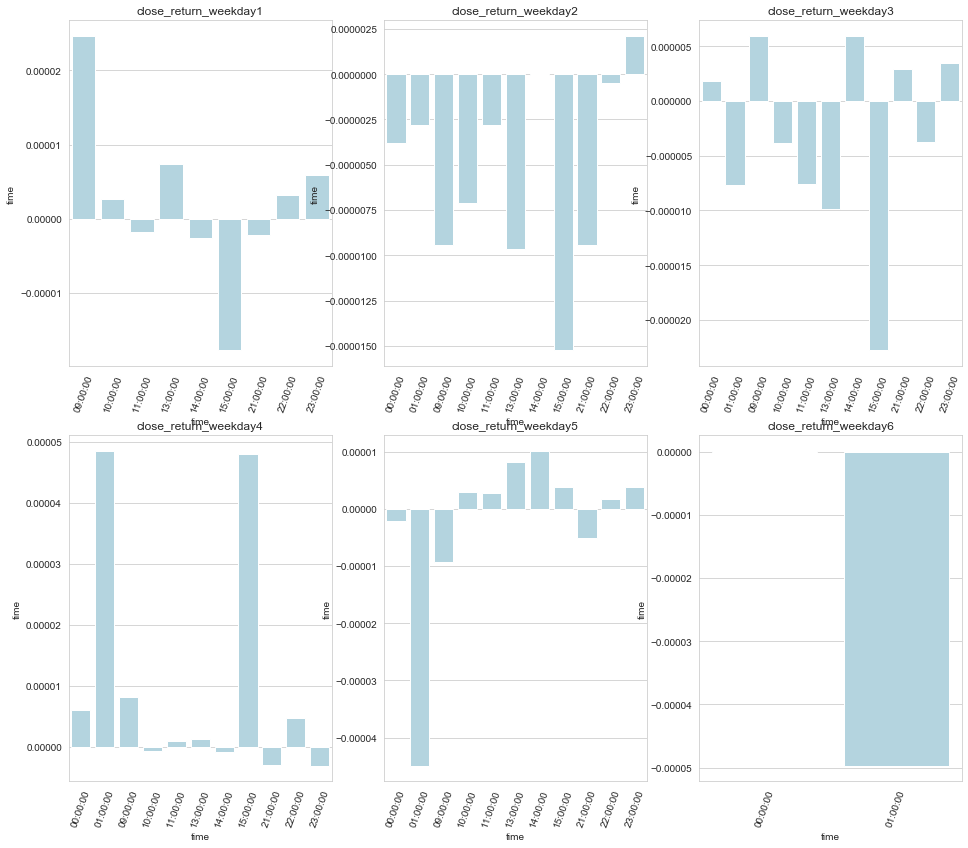

In [213]:
## plotting for bucket and weekdays
fig, axes = plt.subplots(2,3, figsize=(16,14), squeeze = False)
# i = weekly_30m.loc[(slice(None),2),:]
for i in range(6):
    x = weekly_1h[weekly_1h.index==i+1]['time']
    y = weekly_1h[weekly_1h.index==i+1]['close_return']
    ax = axes[i//3, i%3]
    sns.barplot(x=x,y=y, ax=ax,color = 'lightblue')
    sns.set_style("whitegrid")
    ax.set_title('close_return_weekday'+str(i+1))
    ax.set_ylabel("return")
    ax.set_ylabel("time")
    ax.set_xticklabels(x, rotation=70)

The result of 1h level is quite similar to that of 30 mins level, we need to double check it.

In [224]:
pd.value_counts(weekly_30m.time)

14:00:00    5
09:00:00    5
11:30:00    5
10:30:00    5
15:00:00    5
21:30:00    5
13:30:00    5
10:00:00    5
14:30:00    5
00:00:00    5
22:00:00    5
01:00:00    5
09:30:00    5
00:30:00    5
11:00:00    5
23:00:00    5
22:30:00    5
23:30:00    5
21:00:00    5
Name: time, dtype: int64

In [220]:
pd.value_counts(weekly_1h.time)

14:00:00    5
10:00:00    5
22:00:00    5
13:00:00    5
23:00:00    5
11:00:00    5
15:00:00    5
01:00:00    5
00:00:00    5
09:00:00    5
21:00:00    5
Name: time, dtype: int64

we can see that the segmentations of both time bucket are quite balanced 

#### monthly 

In [240]:
## monthly level of close price return
close_return = pd.DataFrame(cu_data.ta.percent_return()).set_index(cu_data.date)
close_return.columns = ['close_return']

## copy close return as cu_monthly data frame
cu_monthly= close_return.copy()

## add the month, weekday of each row
cu_monthly['month'] = cu_monthly.index.map(lambda x: x.month)
cu_monthly['is_weekday'] = cu_monthly.index.map(lambda x: datetime.date.isoweekday(x))
cu_monthly.tail()

,close_return,month,is_weekday
date,,,
2019-06-29 00:56:00,0.000213,6,6
2019-06-29 00:57:00,-0.000212,6,6
2019-06-29 00:58:00,0.000000,6,6
2019-06-29 00:59:00,-0.000213,6,6
2019-06-29 01:00:00,-0.000425,6,6


In [241]:
## group by weekday and month
weekday_month = cu_monthly.groupby(['month','is_weekday']).mean().dropna()
weekday_month =  weekday_month.reset_index(['month'])
weekday_month.head()

,month,close_return
is_weekday,,
1,1,0.000003
2,1,-0.000003
3,1,0.000003
4,1,0.000002
5,1,-0.000002


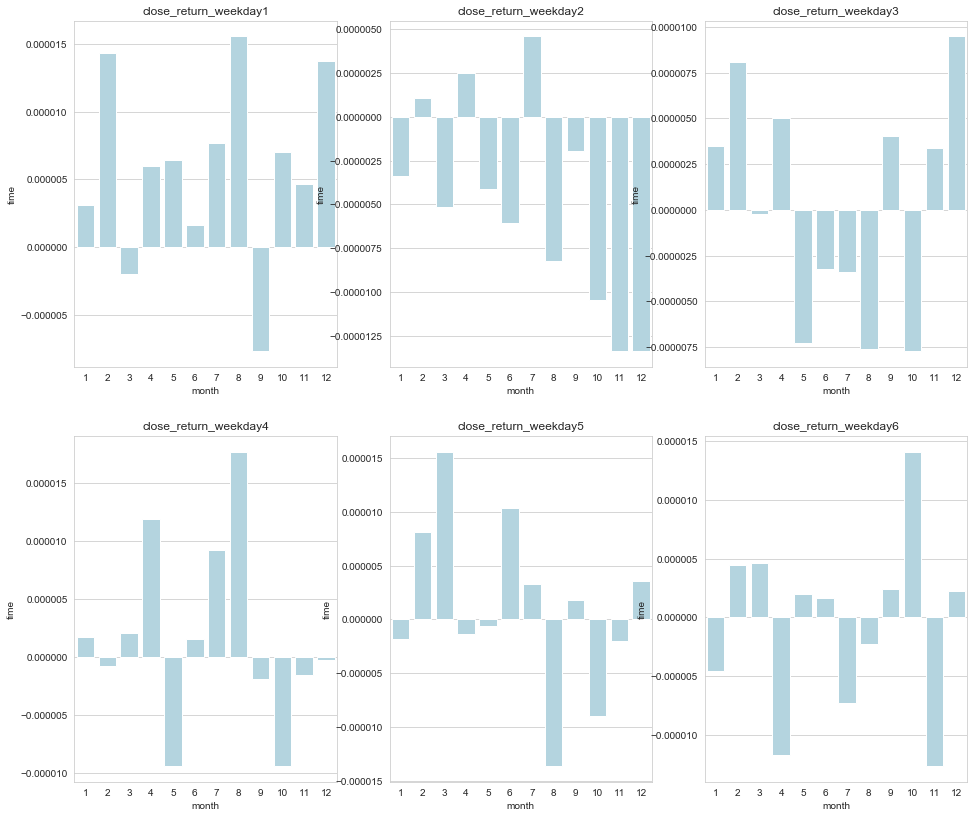

In [245]:
## plotting for months and weekdays
fig, axes = plt.subplots(2,3, figsize=(16,14), squeeze = False)
# i = weekly_30m.loc[(slice(None),2),:]
for i in range(6):
    x = weekday_month[weekday_month.index==i+1]['month']
    y = weekday_month[weekday_month.index==i+1]['close_return']
    ax = axes[i//3, i%3]
    sns.barplot(x=x,y=y, ax=ax,color = 'lightblue')
    sns.set_style("whitegrid")
    ax.set_title('close_return_weekday'+str(i+1))
    ax.set_ylabel("return")
    ax.set_ylabel("time")
    ax.set_xticklabels(x, rotation=0)

At monthly level, we can see that, the result is consistent with what we got from 30mins and 1 hour level.

#### Seasonly

In [301]:
weekday_month.head()

,month,close_return,season
is_weekday,,,
1,1,0.000003,0
2,1,-0.000003,0
3,1,0.000003,0
4,1,0.000002,0
5,1,-0.000002,0


In [309]:
## adding seasons into weekday_month
a = [1]*18
b = [2]*18
c = [3]*18
d = [4]*18
new_col = a + b + c + d
weekday_season = weekday_month.copy()
weekday_season['season'] = new_col
weekday_season.drop(columns=['month'], inplace = True)
weekday_season.reset_index(inplace = True)
weekday_season.head()

,is_weekday,close_return,season
0,1,0.000003,1
1,2,-0.000003,1
2,3,0.000003,1
3,4,0.000002,1
4,5,-0.000002,1


In [314]:
## group by weekday and season
weekday_season = weekday_season.groupby(['season','is_weekday']).mean().dropna()
weekday_season = weekday_season.reset_index(['season'])
weekday_season.head()

,season,close_return
is_weekday,,
1,1,0.000005
2,1,-0.000002
3,1,0.000004
4,1,0.000001
5,1,0.000007


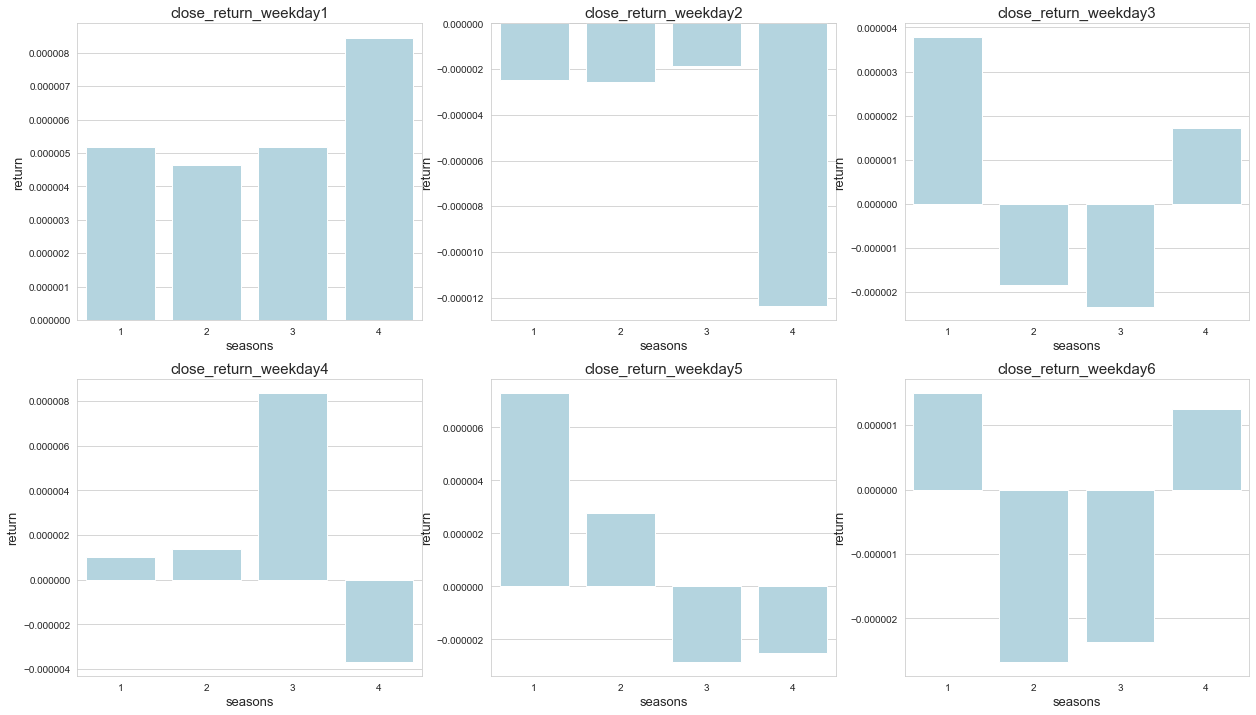

In [371]:
## plotting for months and weekdays
fig, axes = plt.subplots(2,3, figsize=(21,12), squeeze = False)
# i = weekly_30m.loc[(slice(None),2),:]
for i in range(6):
    x = weekday_season[weekday_season.index==i+1]['season']
    y = weekday_season[weekday_season.index==i+1]['close_return']
    ax = axes[i//3, i%3]
    sns.barplot(x=x,y=y, ax=ax,color = 'lightblue')
    sns.set_style("whitegrid")
    ax.set_title('close_return_weekday'+str(i+1), size=15)
    ax.set_ylabel("return",size=13)
    ax.set_xlabel("seasons", size=13)
    ax.set_xticklabels(x, rotation=0)

At seasonly level, we can see that, the result of Tuesday is consistent with what we got from 30mins and 1 hour level.

#### dsitrbution of close return price on Tuesday in different buckets

Text(0.5, 0, 'season')

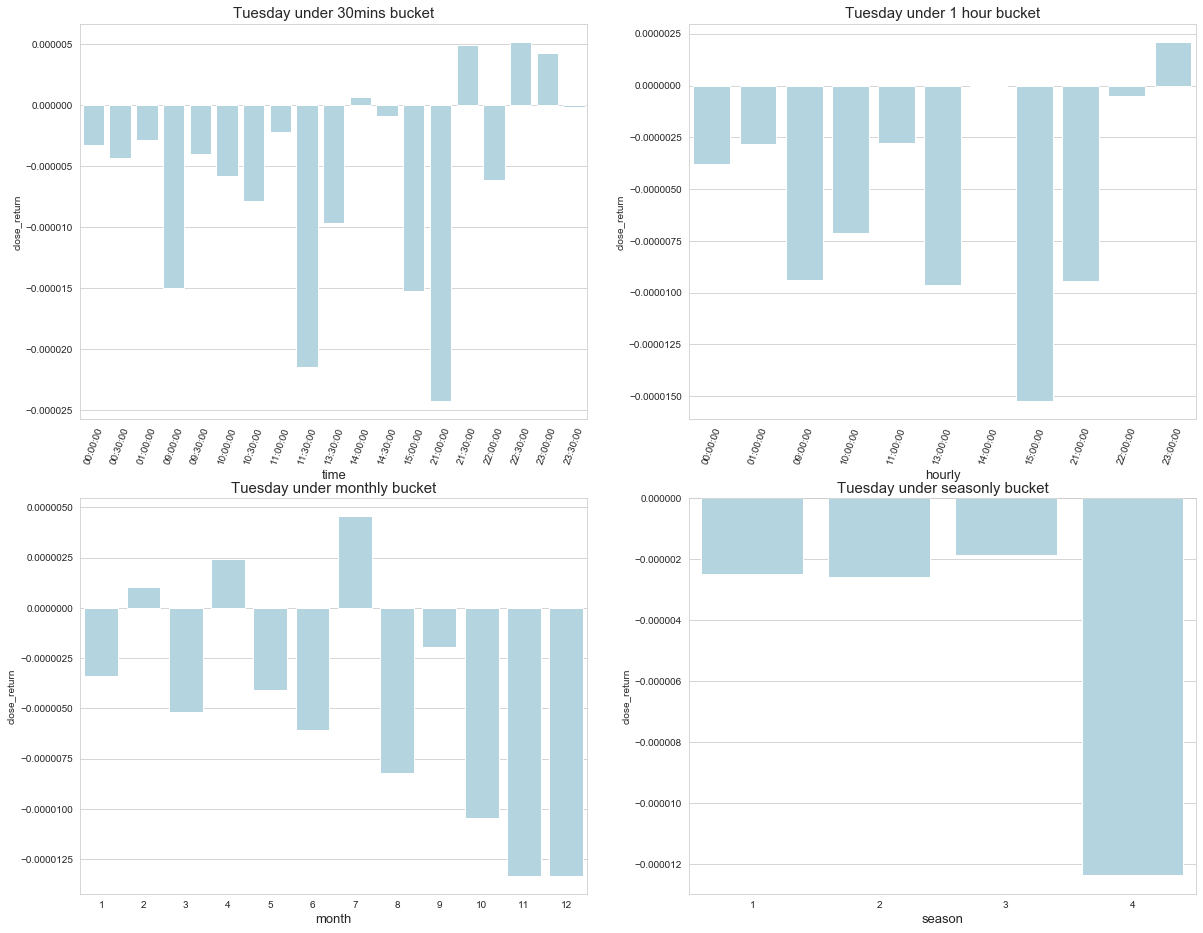

In [379]:
## get data for Tuesday for different buckets
tuesday_30m = weekly_30m[weekly_30m.index==2]
tuesday_1h = weekly_1h[weekly_1h.index==2]
tuesday_month = weekday_month[weekday_month.index==2]
tuesday_season = weekday_season[weekday_season.index==2]

## plot distributions of Tuesday under different buckets
fig,axes = plt.subplots(2,2,figsize=(20,16), squeeze=False)
sns.barplot(x=tuesday_30m['time'], y=tuesday_30m['close_return'] , ax=axes[0,0],color='lightblue')
axes[0,0].set_title('Tuesday under 30mins bucket', size =15)
axes[0,0].set_xticklabels(tuesday_30m['time'], rotation=70)
axes[0,0].set_xlabel('time',size=13)

sns.barplot(x=tuesday_1h['time'], y=tuesday_1h['close_return'], ax=axes[0,1],color='lightblue')
axes[0,1].set_title('Tuesday under 1 hour bucket', size =15)
axes[0,1].set_xticklabels(tuesday_1h['time'], rotation=70)
axes[0,1].set_xlabel('hourly',size=13)

sns.barplot(x=tuesday_month['month'], y=tuesday_month['close_return'], ax=axes[1,0],color='lightblue')
axes[1,0].set_title('Tuesday under monthly bucket',size =15)
axes[1,0].set_xlabel('month',size=13)

sns.barplot(x=tuesday_season['season'], y=tuesday_season['close_return'], ax=axes[1,1],color='lightblue')
axes[1,1].set_title('Tuesday under seasonly bucket',size =15)
axes[1,1].set_xlabel('season',size=13)

From the graph above, we can see that there's a pattern of price return on Tuesdays. It seems that, we can make money if we going short on Tuesdays. So it can be a feature. The new feature can be: the row is 1 if it's Tuesday, else 0.

### Periodiac Analysis

In [488]:
from sklearn.decomposition import PCA
import numpy as np
X = np.array([[-1, 1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca=PCA(n_components=1)
pca.fit(X)
print(pca.transform(X))

[[ 0.50917706]
 [ 2.40151069]
 [ 3.7751606 ]
 [-1.20075534]
 [-2.05572155]
 [-3.42937146]]


In [489]:
print(X)

[[-1  1]
 [-2 -1]
 [-3 -2]
 [ 1  1]
 [ 2  1]
 [ 3  2]]


In [494]:
b = np.array(cu_data['close'].head())

In [500]:
np.dot(b, b.T)

-67897496

In [501]:
from numpy.linalg import svd

In [502]:
u, s, vh = np.linalg.svd(b)

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [487]:
def markov():
    init_array = np.array([0.1, 0.2, 0.7])
    transfer_matrix = np.array([[0.9, 0.075, 0.025],
                               [0.15, 0.8, 0.05],
                               [0.25, 0.25, 0.5]])
    restmp = init_array
    for i in range(25):
        res = np.dot(restmp, transfer_matrix)
        print(i, "\t", res)
        restmp = res

markov()

0 	 [0.295  0.3425 0.3625]
1 	 [0.4075  0.38675 0.20575]
2 	 [0.4762 0.3914 0.1324]
3 	 [0.52039  0.381935 0.097675]
4 	 [0.55006  0.368996 0.080944]
5 	 [0.5706394 0.3566873 0.0726733]
6 	 [0.58524688 0.34631612 0.068437  ]
7 	 [0.59577886 0.33805566 0.06616548]
8 	 [0.60345069 0.33166931 0.06487999]
9 	 [0.60907602 0.32681425 0.06410973]
10 	 [0.61321799 0.32315953 0.06362248]
11 	 [0.61627574 0.3204246  0.06329967]
12 	 [0.61853677 0.31838527 0.06307796]
13 	 [0.62021037 0.31686797 0.06292166]
14 	 [0.62144995 0.31574057 0.06280949]
15 	 [0.62236841 0.31490357 0.06272802]
16 	 [0.62304911 0.31428249 0.0626684 ]
17 	 [0.62355367 0.31382178 0.06262455]
18 	 [0.62392771 0.31348008 0.06259221]
19 	 [0.624205  0.3132267 0.0625683]
20 	 [0.62441058 0.31303881 0.06255061]
21 	 [0.624563   0.31289949 0.06253751]
22 	 [0.624676  0.3127962 0.0625278]
23 	 [0.62475978 0.31271961 0.06252061]
24 	 [0.6248219  0.31266282 0.06251528]


In [504]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
import pandas as pd
import datetime

In [505]:
cu_data.head()

,date,open,close,high,low,volume,money,open_interest
0,2005-01-04 09:01:00,29110,29080,29170,29080,3158,459908300,121604
1,2005-01-04 09:02:00,29080,29100,29100,29030,1970,286417600,121806
2,2005-01-04 09:03:00,29110,29060,29110,29060,1418,206240600,122000
3,2005-01-04 09:04:00,29060,29070,29080,29050,942,136908100,122024
4,2005-01-04 09:05:00,29080,29070,29090,29060,1134,164892800,122198


In [707]:
logDel = np.log(np.array(cu_data['high'])) - np.log(np.array(cu_data['low']))
logRet_1 = np.array(np.diff(np.log(cu_data['close'])))#这个作为后面计算收益使用

logRet_5 = np.log(np.array(cu_data['close'][5:])) - np.log(np.array(cu_data['close'][:-5]))
# logVol_5 = np.log(np.array(cu_data['volume'][5:])) - np.log(np.array(cu_data['volume'][:-5]))
ret = np.array(cu_data.ta.percent_return().dropna())
ret = ret[4:]
len(ret)

1106125

In [708]:
logDel = logDel[5:]
logRet_1 = logRet_1[4:]
Date = pd.to_datetime(cu_data['date'])

Date = Date[5:]
close=cu_data['close']
close = close[5:]

In [709]:
print(len(close))
print(len(Date))
print(len(logDel))
print(len(logRet_1))

1106125
1106125
1106125
1106125


In [710]:
A = np.column_stack([logDel,logRet_5,ret])
A = pd.DataFrame(A).replace([np.inf, -np.inf], np.nan).dropna()
# A = np.array(A)
# A = A[1000000:1010000]

In [711]:
A.head()

,0,1,2
0,0.002065,-0.001721,-0.001376
1,0.002760,-0.004823,-0.002411
2,0.001382,-0.003447,0.000000
3,0.001036,-0.003446,0.000345
4,0.001724,-0.002411,0.001036


In [712]:
A.shape

(1106125, 3)

In [726]:
model = GaussianHMM(n_components= 3, covariance_type="full", n_iter=2000).fit(A)
hidden_states = model.predict(A)
hidden_states

array([1, 1, 2, ..., 0, 0, 0])

In [715]:
hidden_states1 = hidden_states

In [723]:
len(hidden_states1[hidden_states1==1])

574743

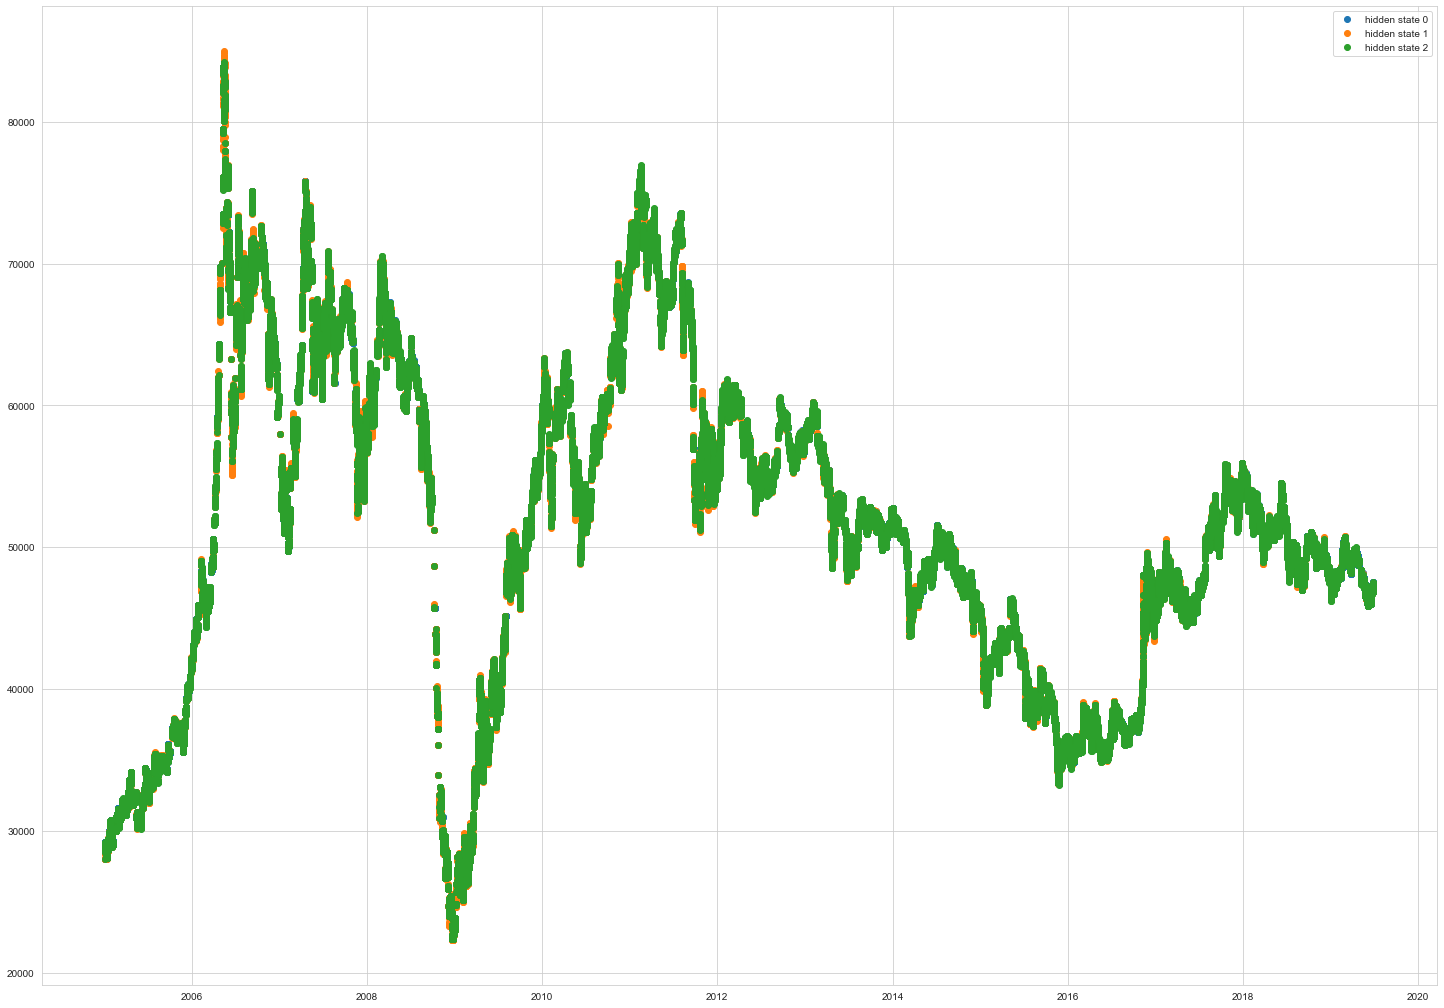

In [727]:
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (hidden_states==i)
    plt.plot_date(Date[pos],close[pos],'o',label='hidden state %d'%i,lw=2)
    plt.legend(loc="left")

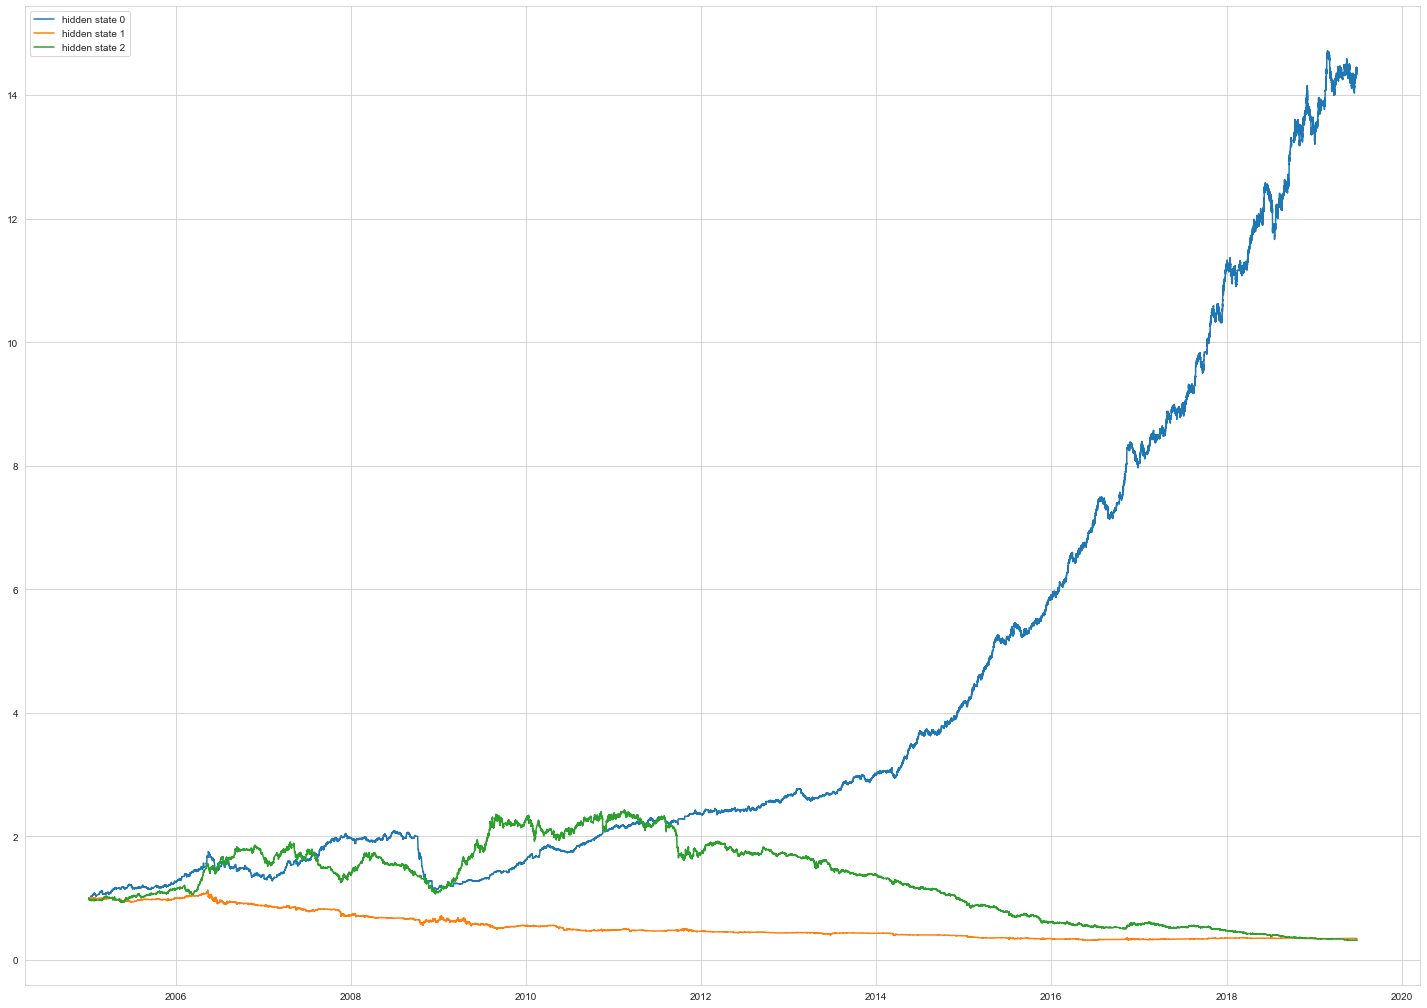

In [728]:
res = pd.DataFrame({'Date':Date,'logRet_1':logRet_1,'state':hidden_states}).set_index('Date')
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (hidden_states==i)
    pos = np.append(0,pos[:-1])#第二天进行买入操作
    df = res.logRet_1
    res['state_ret%s'%i] = df.multiply(pos)
    plt.plot_date(Date,np.exp(res['state_ret%s'%i].cumsum()),'-',label='hidden state %d'%i)
    plt.legend(loc="left")

In [766]:
a  = np.array([[1,2,3],[2,4,6],[3,6,9]])
A = np.matrix(a)

In [767]:
A

matrix([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]])

In [768]:
A.T

matrix([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]])

In [771]:
A*A

matrix([[ 14,  28,  42],
        [ 28,  56,  84],
        [ 42,  84, 126]])

ValueError: shapes (3,3) and (1,3) not aligned: 3 (dim 1) != 1 (dim 0)

In [791]:
planet_data =  pd.DataFrame([['Jupiter', 778000, 71492, 1.90e27],
                        ['Saturn',1429000, 60268, 5.69e26],
                        ['Uranus',2870990, 25559, 8.69e25],
                        ['Neptune', 4504300, 24764, 1.02e26],
                        ['Earth', 149600, 6378, 5.98e24],
                        ['Venus', 108200, 6052, 4.87e24],
                        ['Mars', 227940, 3398, 6.42e23],
                        ['Mercury', 57910, 2439, 3.30e23],
                        ['Pluto', 5913520, 1160, 1.32e22]], 
                         columns=['p', 'd','r','m']).set_index('p')
planet_data

,d,r,m
p,,,
Jupiter,778000,71492,1.900000e+27
Saturn,1429000,60268,5.690000e+26
Uranus,2870990,25559,8.690000e+25
Neptune,4504300,24764,1.020000e+26
Earth,149600,6378,5.980000e+24
Venus,108200,6052,4.870000e+24
Mars,227940,3398,6.420000e+23
Mercury,57910,2439,3.300000e+23
Pluto,5913520,1160,1.320000e+22


In [799]:
a0 = 3.5 * 10e-7
a1 = 1.6 * 10e-5
a2 = 1.1 * 10e-27

In [ ]:
for i in range(9):
    if planet_data.index =='Jupiter':
        planet_data['d'][i]

In [802]:
from scipy.spatial.distance import pdist,squareform

squareform(pdist(planet_data, metric='euclidean'))

array([[0.0000000e+00, 1.3310000e+27, 1.8131000e+27, 1.7980000e+27,
        1.8940200e+27, 1.8951300e+27, 1.8993580e+27, 1.8996700e+27,
        1.8999868e+27],
       [1.3310000e+27, 0.0000000e+00, 4.8210000e+26, 4.6700000e+26,
        5.6302000e+26, 5.6413000e+26, 5.6835800e+26, 5.6867000e+26,
        5.6898680e+26],
       [1.8131000e+27, 4.8210000e+26, 0.0000000e+00, 1.5100000e+25,
        8.0920000e+25, 8.2030000e+25, 8.6258000e+25, 8.6570000e+25,
        8.6886800e+25],
       [1.7980000e+27, 4.6700000e+26, 1.5100000e+25, 0.0000000e+00,
        9.6020000e+25, 9.7130000e+25, 1.0135800e+26, 1.0167000e+26,
        1.0198680e+26],
       [1.8940200e+27, 5.6302000e+26, 8.0920000e+25, 9.6020000e+25,
        0.0000000e+00, 1.1100000e+24, 5.3380000e+24, 5.6500000e+24,
        5.9668000e+24],
       [1.8951300e+27, 5.6413000e+26, 8.2030000e+25, 9.7130000e+25,
        1.1100000e+24, 0.0000000e+00, 4.2280000e+24, 4.5400000e+24,
        4.8568000e+24],
       [1.8993580e+27, 5.6835800e+26, 8.